In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import os
import re
from easydict import EasyDict as edict
from PIL import Image
from skimage import io, transform
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

In [2]:
mask_path = '../input/face-mask-lite-dataset/with_mask'
face_path = '../input/face-mask-lite-dataset/without_mask'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
args = edict()
args.EPOCHS = 10
args.BATCH_SIZE=50
args.LR = 0.0002
args.B1 = 0.5
args.B2 = 0.999
args.N_CPU = 9
args.LATENT_DIM = 100
args.IMG_SIZE = 256
args.CHANNELS = 3
args.NUM_IMG = 10000
args.TRAINING_SIZE = int(0.9*args.NUM_IMG)

In [5]:
class FaceTrainDataset(Dataset):
    def __init__(self, face_path, mask_path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        def sorted_alphanumeric(data):  
            convert = lambda text: int(text) if text.isdigit() else text.lower()
            alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
            return sorted(data,key = alphanum_key)
        
        self.transforms = transforms.Compose(
                            [transforms.Resize([args.IMG_SIZE, args.IMG_SIZE]),
                             transforms.ToTensor(),])
        
        self.face_path = face_path
        self.mask_path = mask_path
        self.face_file = sorted_alphanumeric(os.listdir(face_path))[:args.TRAINING_SIZE]
        self.mask_file = sorted_alphanumeric(os.listdir(mask_path))[:args.TRAINING_SIZE]

    def __len__(self):
        return len(self.face_file)

    def __getitem__(self, idx):
#         image = io.imread(self.file_path + '/' + self.image_file[idx])
        face_image = Image.open(self.face_path + '/' + self.face_file[idx])
        mask_image = Image.open(self.mask_path + '/' + self.mask_file[idx])
        face_image = self.transforms(face_image)
        mask_image = self.transforms(mask_image)

        return (face_image,mask_image)

class FaceTestDataset(Dataset):
    def __init__(self, face_path, mask_path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        def sorted_alphanumeric(data):  
            convert = lambda text: int(text) if text.isdigit() else text.lower()
            alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
            return sorted(data,key = alphanum_key)
        
        self.transforms = transforms.Compose(
                            [transforms.Resize([args.IMG_SIZE, args.IMG_SIZE]),
                             transforms.ToTensor(),])
        
        self.face_path = face_path
        self.mask_path = mask_path
        self.face_file = sorted_alphanumeric(os.listdir(face_path))[args.TRAINING_SIZE:]
        self.mask_file = sorted_alphanumeric(os.listdir(mask_path))[args.TRAINING_SIZE:]

    def __len__(self):
        return len(self.face_file)

    def __getitem__(self, idx):
#         image = io.imread(self.file_path + '/' + self.image_file[idx])
        face_image = Image.open(self.face_path + '/' + self.face_file[idx])
        mask_image = Image.open(self.mask_path + '/' + self.mask_file[idx])
        face_image = self.transforms(face_image)
        mask_image = self.transforms(mask_image)

        return (face_image,mask_image)

In [6]:
train_dataset = FaceTrainDataset(face_path=face_path, mask_path=mask_path)
train_dataloader = DataLoader(train_dataset, batch_size=args.BATCH_SIZE)
test_dataset = FaceTestDataset(face_path=face_path, mask_path=mask_path)
test_dataloader = DataLoader(test_dataset, batch_size=args.BATCH_SIZE)

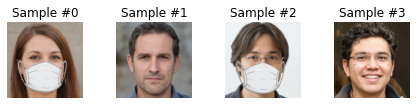

In [7]:
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    if i % 2:
        sample_img = np.transpose(sample[0].cpu().detach().numpy(), (1,2,0))
    else:
        sample_img = np.transpose(sample[1].cpu().detach().numpy(), (1,2,0))
    plt.imshow(sample_img)

    if i == 3:
        plt.show()
        break

In [8]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [9]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [10]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [11]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.d5 = DownSampleConv(512, 512)
        self.d6 = DownSampleConv(512, 512)
        self.d7 = DownSampleConv(512, 512)
        self.d8 = DownSampleConv(512, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)
        
    def forward(self, x):
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        x5 = self.d6(x4)
        x6 = self.d7(x5)
        x7 = self.d8(x6)
        xn = self.final(x7)
        return xn

In [12]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)
mse_loss = torch.nn.MSELoss().to(device)
l1_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
generator = Generator(args.CHANNELS,args.CHANNELS).to(device)
discriminator = PatchGAN(args.CHANNELS).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.LR, betas=(args.B1, args.B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.LR, betas=(args.B1, args.B2))

In [ ]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
generator.apply(_weights_init)
discriminator.apply(_weights_init)

PatchGAN(
  (d1): DownSampleConv(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (act): LeakyReLU(negative_slope=0.2)
  )
  (d2): DownSampleConv(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2)
  )
  (d3): DownSampleConv(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2)
  )
  (d4): DownSampleConv(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2)
  )
  (d5): DownSampleConv(
    (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d

In [14]:
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 1

In [15]:
os.makedirs('./saved_model')

[Epoch 0/10] [Batch 0/180] [D loss: 0.693161] [G loss: 1.162022]


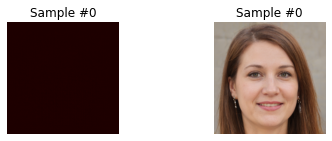

[Epoch 0/10] [Batch 1/180] [D loss: 0.693080] [G loss: 1.158540]
[Epoch 0/10] [Batch 2/180] [D loss: 0.693113] [G loss: 1.155126]
[Epoch 0/10] [Batch 3/180] [D loss: 0.693086] [G loss: 1.163788]
[Epoch 0/10] [Batch 4/180] [D loss: 0.692973] [G loss: 1.155501]
[Epoch 0/10] [Batch 5/180] [D loss: 0.692935] [G loss: 1.152835]
[Epoch 0/10] [Batch 6/180] [D loss: 0.692804] [G loss: 1.157165]
[Epoch 0/10] [Batch 7/180] [D loss: 0.692668] [G loss: 1.143149]
[Epoch 0/10] [Batch 8/180] [D loss: 0.692298] [G loss: 1.162744]
[Epoch 0/10] [Batch 9/180] [D loss: 0.691951] [G loss: 1.134425]
[Epoch 0/10] [Batch 10/180] [D loss: 0.691060] [G loss: 1.161519]
[Epoch 0/10] [Batch 11/180] [D loss: 0.690385] [G loss: 1.169773]
[Epoch 0/10] [Batch 12/180] [D loss: 0.689600] [G loss: 1.149925]
[Epoch 0/10] [Batch 13/180] [D loss: 0.688737] [G loss: 1.174069]
[Epoch 0/10] [Batch 14/180] [D loss: 0.688276] [G loss: 1.172076]
[Epoch 0/10] [Batch 15/180] [D loss: 0.687687] [G loss: 1.165477]
[Epoch 0/10] [Batch

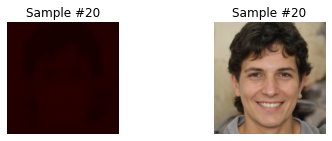

[Epoch 0/10] [Batch 21/180] [D loss: 0.684435] [G loss: 1.159855]
[Epoch 0/10] [Batch 22/180] [D loss: 0.684382] [G loss: 1.133768]
[Epoch 0/10] [Batch 23/180] [D loss: 0.683648] [G loss: 1.123356]
[Epoch 0/10] [Batch 24/180] [D loss: 0.683728] [G loss: 1.171473]
[Epoch 0/10] [Batch 25/180] [D loss: 0.683056] [G loss: 1.142344]
[Epoch 0/10] [Batch 26/180] [D loss: 0.683353] [G loss: 1.141578]
[Epoch 0/10] [Batch 27/180] [D loss: 0.683446] [G loss: 1.159417]
[Epoch 0/10] [Batch 28/180] [D loss: 0.681493] [G loss: 1.132573]
[Epoch 0/10] [Batch 29/180] [D loss: 0.681068] [G loss: 1.136423]
[Epoch 0/10] [Batch 30/180] [D loss: 0.680737] [G loss: 1.133261]
[Epoch 0/10] [Batch 31/180] [D loss: 0.680575] [G loss: 1.147873]
[Epoch 0/10] [Batch 32/180] [D loss: 0.679014] [G loss: 1.144295]
[Epoch 0/10] [Batch 33/180] [D loss: 0.679225] [G loss: 1.146116]
[Epoch 0/10] [Batch 34/180] [D loss: 0.678881] [G loss: 1.125310]
[Epoch 0/10] [Batch 35/180] [D loss: 0.678342] [G loss: 1.151292]
[Epoch 0/1

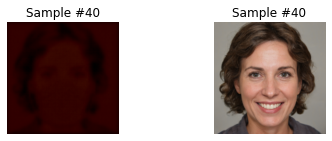

[Epoch 0/10] [Batch 41/180] [D loss: 0.676395] [G loss: 1.107540]
[Epoch 0/10] [Batch 42/180] [D loss: 0.674858] [G loss: 1.129616]
[Epoch 0/10] [Batch 43/180] [D loss: 0.674640] [G loss: 1.114561]
[Epoch 0/10] [Batch 44/180] [D loss: 0.674581] [G loss: 1.108012]
[Epoch 0/10] [Batch 45/180] [D loss: 0.673275] [G loss: 1.104831]
[Epoch 0/10] [Batch 46/180] [D loss: 0.674286] [G loss: 1.129311]
[Epoch 0/10] [Batch 47/180] [D loss: 0.671915] [G loss: 1.099203]
[Epoch 0/10] [Batch 48/180] [D loss: 0.672449] [G loss: 1.099200]
[Epoch 0/10] [Batch 49/180] [D loss: 0.671201] [G loss: 1.099189]
[Epoch 0/10] [Batch 50/180] [D loss: 0.671900] [G loss: 1.094855]
[Epoch 0/10] [Batch 51/180] [D loss: 0.670154] [G loss: 1.094327]
[Epoch 0/10] [Batch 52/180] [D loss: 0.671048] [G loss: 1.069525]
[Epoch 0/10] [Batch 53/180] [D loss: 0.669070] [G loss: 1.098863]
[Epoch 0/10] [Batch 54/180] [D loss: 0.668615] [G loss: 1.109478]
[Epoch 0/10] [Batch 55/180] [D loss: 0.667965] [G loss: 1.082724]
[Epoch 0/1

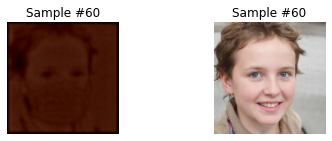

[Epoch 0/10] [Batch 61/180] [D loss: 0.663767] [G loss: 1.072955]
[Epoch 0/10] [Batch 62/180] [D loss: 0.664009] [G loss: 1.083389]
[Epoch 0/10] [Batch 63/180] [D loss: 0.664698] [G loss: 1.053684]
[Epoch 0/10] [Batch 64/180] [D loss: 0.665285] [G loss: 1.039763]
[Epoch 0/10] [Batch 65/180] [D loss: 0.663132] [G loss: 1.061690]
[Epoch 0/10] [Batch 66/180] [D loss: 0.661838] [G loss: 1.043429]
[Epoch 0/10] [Batch 67/180] [D loss: 0.661741] [G loss: 1.058588]
[Epoch 0/10] [Batch 68/180] [D loss: 0.661025] [G loss: 1.035265]
[Epoch 0/10] [Batch 69/180] [D loss: 0.660426] [G loss: 1.033123]
[Epoch 0/10] [Batch 70/180] [D loss: 0.658478] [G loss: 1.027002]
[Epoch 0/10] [Batch 71/180] [D loss: 0.660093] [G loss: 1.041850]
[Epoch 0/10] [Batch 72/180] [D loss: 0.662400] [G loss: 1.030805]
[Epoch 0/10] [Batch 73/180] [D loss: 0.686955] [G loss: 1.023936]
[Epoch 0/10] [Batch 74/180] [D loss: 0.678121] [G loss: 1.017951]
[Epoch 0/10] [Batch 75/180] [D loss: 0.677494] [G loss: 1.000302]
[Epoch 0/1

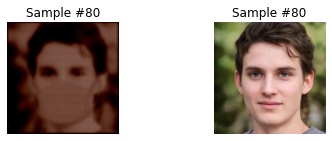

[Epoch 0/10] [Batch 81/180] [D loss: 0.658853] [G loss: 1.014172]
[Epoch 0/10] [Batch 82/180] [D loss: 0.657607] [G loss: 0.995514]
[Epoch 0/10] [Batch 83/180] [D loss: 0.655164] [G loss: 1.013555]
[Epoch 0/10] [Batch 84/180] [D loss: 0.653785] [G loss: 0.988668]
[Epoch 0/10] [Batch 85/180] [D loss: 0.657642] [G loss: 0.979045]
[Epoch 0/10] [Batch 86/180] [D loss: 0.652425] [G loss: 1.002858]
[Epoch 0/10] [Batch 87/180] [D loss: 0.652149] [G loss: 0.975256]
[Epoch 0/10] [Batch 88/180] [D loss: 0.651404] [G loss: 0.982895]
[Epoch 0/10] [Batch 89/180] [D loss: 0.651729] [G loss: 0.968067]
[Epoch 0/10] [Batch 90/180] [D loss: 0.648395] [G loss: 0.989048]
[Epoch 0/10] [Batch 91/180] [D loss: 0.648021] [G loss: 0.985716]
[Epoch 0/10] [Batch 92/180] [D loss: 0.649645] [G loss: 0.960814]
[Epoch 0/10] [Batch 93/180] [D loss: 0.647949] [G loss: 0.944662]
[Epoch 0/10] [Batch 94/180] [D loss: 0.647172] [G loss: 0.950634]
[Epoch 0/10] [Batch 95/180] [D loss: 0.646206] [G loss: 0.958362]
[Epoch 0/1

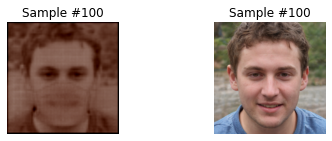

[Epoch 0/10] [Batch 101/180] [D loss: 0.640459] [G loss: 0.920730]
[Epoch 0/10] [Batch 102/180] [D loss: 0.638386] [G loss: 0.921714]
[Epoch 0/10] [Batch 103/180] [D loss: 0.637992] [G loss: 0.917353]
[Epoch 0/10] [Batch 104/180] [D loss: 0.639890] [G loss: 0.907033]
[Epoch 0/10] [Batch 105/180] [D loss: 0.639204] [G loss: 0.908463]
[Epoch 0/10] [Batch 106/180] [D loss: 0.634526] [G loss: 0.913136]
[Epoch 0/10] [Batch 107/180] [D loss: 0.634667] [G loss: 0.905561]
[Epoch 0/10] [Batch 108/180] [D loss: 0.636292] [G loss: 0.900351]
[Epoch 0/10] [Batch 109/180] [D loss: 0.636968] [G loss: 0.904868]
[Epoch 0/10] [Batch 110/180] [D loss: 0.651478] [G loss: 0.888698]
[Epoch 0/10] [Batch 111/180] [D loss: 0.686655] [G loss: 0.799735]
[Epoch 0/10] [Batch 112/180] [D loss: 0.696463] [G loss: 0.788683]
[Epoch 0/10] [Batch 113/180] [D loss: 0.675535] [G loss: 0.818175]
[Epoch 0/10] [Batch 114/180] [D loss: 0.649788] [G loss: 0.905621]
[Epoch 0/10] [Batch 115/180] [D loss: 0.653394] [G loss: 0.883

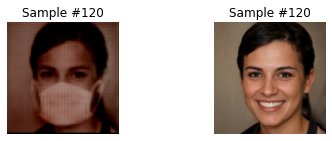

[Epoch 0/10] [Batch 121/180] [D loss: 0.639180] [G loss: 0.868919]
[Epoch 0/10] [Batch 122/180] [D loss: 0.638226] [G loss: 0.865949]
[Epoch 0/10] [Batch 123/180] [D loss: 0.630697] [G loss: 0.861183]
[Epoch 0/10] [Batch 124/180] [D loss: 0.632541] [G loss: 0.866528]
[Epoch 0/10] [Batch 125/180] [D loss: 0.626565] [G loss: 0.847013]
[Epoch 0/10] [Batch 126/180] [D loss: 0.625411] [G loss: 0.870755]
[Epoch 0/10] [Batch 127/180] [D loss: 0.625455] [G loss: 0.863649]
[Epoch 0/10] [Batch 128/180] [D loss: 0.621828] [G loss: 0.852003]
[Epoch 0/10] [Batch 129/180] [D loss: 0.624732] [G loss: 0.847117]
[Epoch 0/10] [Batch 130/180] [D loss: 0.622834] [G loss: 0.849971]
[Epoch 0/10] [Batch 131/180] [D loss: 0.619048] [G loss: 0.860973]
[Epoch 0/10] [Batch 132/180] [D loss: 0.624695] [G loss: 0.841370]
[Epoch 0/10] [Batch 133/180] [D loss: 0.674667] [G loss: 0.747999]
[Epoch 0/10] [Batch 134/180] [D loss: 0.683217] [G loss: 0.861366]
[Epoch 0/10] [Batch 135/180] [D loss: 0.661483] [G loss: 0.812

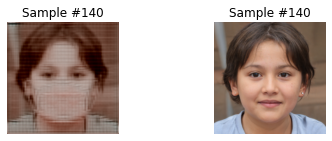

[Epoch 0/10] [Batch 141/180] [D loss: 0.651479] [G loss: 0.837646]
[Epoch 0/10] [Batch 142/180] [D loss: 0.676249] [G loss: 0.760639]
[Epoch 0/10] [Batch 143/180] [D loss: 0.643388] [G loss: 0.835922]
[Epoch 0/10] [Batch 144/180] [D loss: 0.641141] [G loss: 0.835572]
[Epoch 0/10] [Batch 145/180] [D loss: 0.634120] [G loss: 0.840063]
[Epoch 0/10] [Batch 146/180] [D loss: 0.627329] [G loss: 0.825689]
[Epoch 0/10] [Batch 147/180] [D loss: 0.629081] [G loss: 0.825115]
[Epoch 0/10] [Batch 148/180] [D loss: 0.643524] [G loss: 0.824078]
[Epoch 0/10] [Batch 149/180] [D loss: 0.648855] [G loss: 0.800427]
[Epoch 0/10] [Batch 150/180] [D loss: 0.693579] [G loss: 0.859638]
[Epoch 0/10] [Batch 151/180] [D loss: 0.690667] [G loss: 0.849433]
[Epoch 0/10] [Batch 152/180] [D loss: 0.688328] [G loss: 0.811650]
[Epoch 0/10] [Batch 153/180] [D loss: 0.702673] [G loss: 0.753624]
[Epoch 0/10] [Batch 154/180] [D loss: 0.689064] [G loss: 0.770555]
[Epoch 0/10] [Batch 155/180] [D loss: 0.686073] [G loss: 0.727

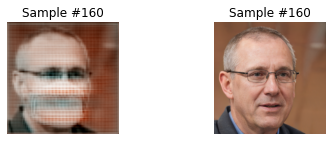

[Epoch 0/10] [Batch 161/180] [D loss: 0.672095] [G loss: 0.784823]
[Epoch 0/10] [Batch 162/180] [D loss: 0.681975] [G loss: 0.742982]
[Epoch 0/10] [Batch 163/180] [D loss: 0.681397] [G loss: 0.751330]
[Epoch 0/10] [Batch 164/180] [D loss: 0.669751] [G loss: 0.788593]
[Epoch 0/10] [Batch 165/180] [D loss: 0.672264] [G loss: 0.797618]
[Epoch 0/10] [Batch 166/180] [D loss: 0.672398] [G loss: 0.821555]
[Epoch 0/10] [Batch 167/180] [D loss: 0.672126] [G loss: 0.768829]
[Epoch 0/10] [Batch 168/180] [D loss: 0.684010] [G loss: 0.822456]
[Epoch 0/10] [Batch 169/180] [D loss: 0.687889] [G loss: 0.750453]
[Epoch 0/10] [Batch 170/180] [D loss: 0.688314] [G loss: 0.764330]
[Epoch 0/10] [Batch 171/180] [D loss: 0.671509] [G loss: 0.779908]
[Epoch 0/10] [Batch 172/180] [D loss: 0.679774] [G loss: 0.796157]
[Epoch 0/10] [Batch 173/180] [D loss: 0.693227] [G loss: 0.716064]
[Epoch 0/10] [Batch 174/180] [D loss: 0.687996] [G loss: 0.830431]
[Epoch 0/10] [Batch 175/180] [D loss: 0.670564] [G loss: 0.785

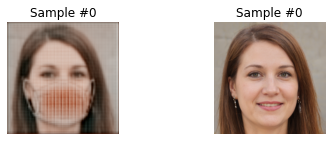

[Epoch 1/10] [Batch 1/180] [D loss: 0.682238] [G loss: 0.721362]
[Epoch 1/10] [Batch 2/180] [D loss: 0.671177] [G loss: 0.765898]
[Epoch 1/10] [Batch 3/180] [D loss: 0.667751] [G loss: 0.804089]
[Epoch 1/10] [Batch 4/180] [D loss: 0.660162] [G loss: 0.776495]
[Epoch 1/10] [Batch 5/180] [D loss: 0.679883] [G loss: 0.750286]
[Epoch 1/10] [Batch 6/180] [D loss: 0.676065] [G loss: 0.813306]
[Epoch 1/10] [Batch 7/180] [D loss: 0.668845] [G loss: 0.819675]
[Epoch 1/10] [Batch 8/180] [D loss: 0.657320] [G loss: 0.818825]
[Epoch 1/10] [Batch 9/180] [D loss: 0.645772] [G loss: 0.834686]
[Epoch 1/10] [Batch 10/180] [D loss: 0.663940] [G loss: 0.779713]
[Epoch 1/10] [Batch 11/180] [D loss: 0.658074] [G loss: 0.807241]
[Epoch 1/10] [Batch 12/180] [D loss: 0.653809] [G loss: 0.831222]
[Epoch 1/10] [Batch 13/180] [D loss: 0.643284] [G loss: 0.805794]
[Epoch 1/10] [Batch 14/180] [D loss: 0.678078] [G loss: 0.751057]
[Epoch 1/10] [Batch 15/180] [D loss: 0.682875] [G loss: 0.770509]
[Epoch 1/10] [Batch

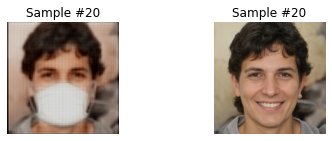

[Epoch 1/10] [Batch 21/180] [D loss: 0.656290] [G loss: 0.833110]
[Epoch 1/10] [Batch 22/180] [D loss: 0.641624] [G loss: 0.834845]
[Epoch 1/10] [Batch 23/180] [D loss: 0.644041] [G loss: 0.813135]
[Epoch 1/10] [Batch 24/180] [D loss: 0.656839] [G loss: 0.798738]
[Epoch 1/10] [Batch 25/180] [D loss: 0.629029] [G loss: 0.835191]
[Epoch 1/10] [Batch 26/180] [D loss: 0.631291] [G loss: 0.831085]
[Epoch 1/10] [Batch 27/180] [D loss: 0.631475] [G loss: 0.823520]
[Epoch 1/10] [Batch 28/180] [D loss: 0.630853] [G loss: 0.828584]
[Epoch 1/10] [Batch 29/180] [D loss: 0.623889] [G loss: 0.817557]
[Epoch 1/10] [Batch 30/180] [D loss: 0.617194] [G loss: 0.833416]
[Epoch 1/10] [Batch 31/180] [D loss: 0.622465] [G loss: 0.818041]
[Epoch 1/10] [Batch 32/180] [D loss: 0.622949] [G loss: 0.813256]
[Epoch 1/10] [Batch 33/180] [D loss: 0.617855] [G loss: 0.830749]
[Epoch 1/10] [Batch 34/180] [D loss: 0.616857] [G loss: 0.816800]
[Epoch 1/10] [Batch 35/180] [D loss: 0.610075] [G loss: 0.833692]
[Epoch 1/1

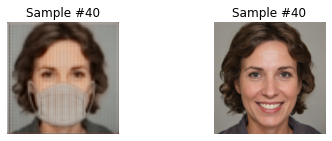

[Epoch 1/10] [Batch 41/180] [D loss: 0.668186] [G loss: 0.842933]
[Epoch 1/10] [Batch 42/180] [D loss: 0.686938] [G loss: 0.790255]
[Epoch 1/10] [Batch 43/180] [D loss: 0.658426] [G loss: 0.896605]
[Epoch 1/10] [Batch 44/180] [D loss: 0.639651] [G loss: 0.835092]
[Epoch 1/10] [Batch 45/180] [D loss: 0.637081] [G loss: 0.806607]
[Epoch 1/10] [Batch 46/180] [D loss: 0.653542] [G loss: 0.770295]
[Epoch 1/10] [Batch 47/180] [D loss: 0.617141] [G loss: 0.828015]
[Epoch 1/10] [Batch 48/180] [D loss: 0.623787] [G loss: 0.817706]
[Epoch 1/10] [Batch 49/180] [D loss: 0.605044] [G loss: 0.860332]
[Epoch 1/10] [Batch 50/180] [D loss: 0.605886] [G loss: 0.855632]
[Epoch 1/10] [Batch 51/180] [D loss: 0.607304] [G loss: 0.849611]
[Epoch 1/10] [Batch 52/180] [D loss: 0.607075] [G loss: 0.841158]
[Epoch 1/10] [Batch 53/180] [D loss: 0.662928] [G loss: 0.802468]
[Epoch 1/10] [Batch 54/180] [D loss: 0.657653] [G loss: 0.866853]
[Epoch 1/10] [Batch 55/180] [D loss: 0.625137] [G loss: 0.818744]
[Epoch 1/1

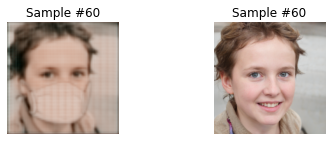

[Epoch 1/10] [Batch 61/180] [D loss: 0.586735] [G loss: 0.856652]
[Epoch 1/10] [Batch 62/180] [D loss: 0.582423] [G loss: 0.868019]
[Epoch 1/10] [Batch 63/180] [D loss: 0.580012] [G loss: 0.862885]
[Epoch 1/10] [Batch 64/180] [D loss: 0.571236] [G loss: 0.868178]
[Epoch 1/10] [Batch 65/180] [D loss: 0.569694] [G loss: 0.872306]
[Epoch 1/10] [Batch 66/180] [D loss: 0.573536] [G loss: 0.864124]
[Epoch 1/10] [Batch 67/180] [D loss: 0.575053] [G loss: 0.863581]
[Epoch 1/10] [Batch 68/180] [D loss: 0.576442] [G loss: 0.838932]
[Epoch 1/10] [Batch 69/180] [D loss: 0.599685] [G loss: 0.864405]
[Epoch 1/10] [Batch 70/180] [D loss: 0.575812] [G loss: 0.860954]
[Epoch 1/10] [Batch 71/180] [D loss: 0.567342] [G loss: 0.862267]
[Epoch 1/10] [Batch 72/180] [D loss: 0.568595] [G loss: 0.854468]
[Epoch 1/10] [Batch 73/180] [D loss: 0.666797] [G loss: 0.676394]
[Epoch 1/10] [Batch 74/180] [D loss: 0.672970] [G loss: 0.931089]
[Epoch 1/10] [Batch 75/180] [D loss: 0.662621] [G loss: 0.942769]
[Epoch 1/1

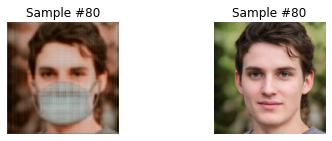

[Epoch 1/10] [Batch 81/180] [D loss: 0.605604] [G loss: 0.888747]
[Epoch 1/10] [Batch 82/180] [D loss: 0.583344] [G loss: 0.878534]
[Epoch 1/10] [Batch 83/180] [D loss: 0.588069] [G loss: 0.847548]
[Epoch 1/10] [Batch 84/180] [D loss: 0.588959] [G loss: 0.831395]
[Epoch 1/10] [Batch 85/180] [D loss: 0.580471] [G loss: 0.848204]
[Epoch 1/10] [Batch 86/180] [D loss: 0.592542] [G loss: 0.873644]
[Epoch 1/10] [Batch 87/180] [D loss: 0.584695] [G loss: 0.868465]
[Epoch 1/10] [Batch 88/180] [D loss: 0.568161] [G loss: 0.882340]
[Epoch 1/10] [Batch 89/180] [D loss: 0.587079] [G loss: 0.844590]
[Epoch 1/10] [Batch 90/180] [D loss: 0.665612] [G loss: 0.739160]
[Epoch 1/10] [Batch 91/180] [D loss: 0.665628] [G loss: 0.795195]
[Epoch 1/10] [Batch 92/180] [D loss: 0.621594] [G loss: 0.871963]
[Epoch 1/10] [Batch 93/180] [D loss: 0.609917] [G loss: 0.870969]
[Epoch 1/10] [Batch 94/180] [D loss: 0.593236] [G loss: 0.874037]
[Epoch 1/10] [Batch 95/180] [D loss: 0.629960] [G loss: 0.804578]
[Epoch 1/1

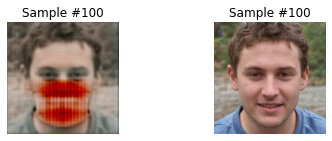

[Epoch 1/10] [Batch 101/180] [D loss: 0.574464] [G loss: 0.865125]
[Epoch 1/10] [Batch 102/180] [D loss: 0.549494] [G loss: 0.924471]
[Epoch 1/10] [Batch 103/180] [D loss: 0.553928] [G loss: 0.892438]
[Epoch 1/10] [Batch 104/180] [D loss: 0.545130] [G loss: 0.926803]
[Epoch 1/10] [Batch 105/180] [D loss: 0.548231] [G loss: 0.902449]
[Epoch 1/10] [Batch 106/180] [D loss: 0.568167] [G loss: 0.868010]
[Epoch 1/10] [Batch 107/180] [D loss: 0.625219] [G loss: 0.870059]
[Epoch 1/10] [Batch 108/180] [D loss: 0.626864] [G loss: 0.935198]
[Epoch 1/10] [Batch 109/180] [D loss: 0.681260] [G loss: 0.737641]
[Epoch 1/10] [Batch 110/180] [D loss: 0.578725] [G loss: 0.920526]
[Epoch 1/10] [Batch 111/180] [D loss: 0.566753] [G loss: 0.917421]
[Epoch 1/10] [Batch 112/180] [D loss: 0.555450] [G loss: 0.936337]
[Epoch 1/10] [Batch 113/180] [D loss: 0.550924] [G loss: 0.911907]
[Epoch 1/10] [Batch 114/180] [D loss: 0.555314] [G loss: 0.933712]
[Epoch 1/10] [Batch 115/180] [D loss: 0.551010] [G loss: 0.901

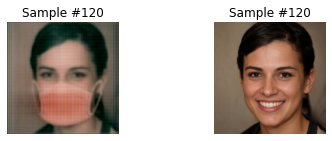

[Epoch 1/10] [Batch 121/180] [D loss: 0.566902] [G loss: 0.932798]
[Epoch 1/10] [Batch 122/180] [D loss: 0.576567] [G loss: 0.972835]
[Epoch 1/10] [Batch 123/180] [D loss: 0.554435] [G loss: 0.973025]
[Epoch 1/10] [Batch 124/180] [D loss: 0.547729] [G loss: 0.945242]
[Epoch 1/10] [Batch 125/180] [D loss: 0.569006] [G loss: 0.865228]
[Epoch 1/10] [Batch 126/180] [D loss: 0.535296] [G loss: 0.931470]
[Epoch 1/10] [Batch 127/180] [D loss: 0.524513] [G loss: 0.961617]
[Epoch 1/10] [Batch 128/180] [D loss: 0.516052] [G loss: 0.970965]
[Epoch 1/10] [Batch 129/180] [D loss: 0.514362] [G loss: 0.965792]
[Epoch 1/10] [Batch 130/180] [D loss: 0.515714] [G loss: 0.974546]
[Epoch 1/10] [Batch 131/180] [D loss: 0.508280] [G loss: 0.978446]
[Epoch 1/10] [Batch 132/180] [D loss: 0.506283] [G loss: 0.974417]
[Epoch 1/10] [Batch 133/180] [D loss: 0.507836] [G loss: 0.961988]
[Epoch 1/10] [Batch 134/180] [D loss: 0.699041] [G loss: 0.597151]
[Epoch 1/10] [Batch 135/180] [D loss: 0.572425] [G loss: 0.879

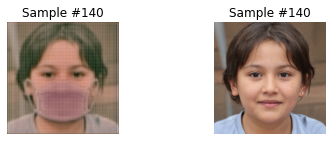

[Epoch 1/10] [Batch 141/180] [D loss: 0.655951] [G loss: 0.872410]
[Epoch 1/10] [Batch 142/180] [D loss: 0.619935] [G loss: 0.976162]
[Epoch 1/10] [Batch 143/180] [D loss: 0.581901] [G loss: 0.940198]
[Epoch 1/10] [Batch 144/180] [D loss: 0.550399] [G loss: 0.964478]
[Epoch 1/10] [Batch 145/180] [D loss: 0.541479] [G loss: 0.968022]
[Epoch 1/10] [Batch 146/180] [D loss: 0.529196] [G loss: 0.981342]
[Epoch 1/10] [Batch 147/180] [D loss: 0.518531] [G loss: 0.992308]
[Epoch 1/10] [Batch 148/180] [D loss: 0.579856] [G loss: 0.846814]
[Epoch 1/10] [Batch 149/180] [D loss: 0.579319] [G loss: 0.983440]
[Epoch 1/10] [Batch 150/180] [D loss: 0.673303] [G loss: 0.663470]
[Epoch 1/10] [Batch 151/180] [D loss: 0.572587] [G loss: 0.981616]
[Epoch 1/10] [Batch 152/180] [D loss: 0.590125] [G loss: 0.952329]
[Epoch 1/10] [Batch 153/180] [D loss: 0.647748] [G loss: 0.749578]
[Epoch 1/10] [Batch 154/180] [D loss: 0.588382] [G loss: 0.985248]
[Epoch 1/10] [Batch 155/180] [D loss: 0.564674] [G loss: 0.909

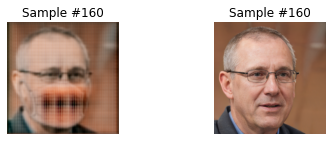

[Epoch 1/10] [Batch 161/180] [D loss: 0.600053] [G loss: 0.984348]
[Epoch 1/10] [Batch 162/180] [D loss: 0.591679] [G loss: 0.826214]
[Epoch 1/10] [Batch 163/180] [D loss: 0.579588] [G loss: 0.884528]
[Epoch 1/10] [Batch 164/180] [D loss: 0.655194] [G loss: 0.990864]
[Epoch 1/10] [Batch 165/180] [D loss: 0.631595] [G loss: 0.811169]
[Epoch 1/10] [Batch 166/180] [D loss: 0.668895] [G loss: 0.756661]
[Epoch 1/10] [Batch 167/180] [D loss: 0.643605] [G loss: 0.820171]
[Epoch 1/10] [Batch 168/180] [D loss: 0.690413] [G loss: 0.791928]
[Epoch 1/10] [Batch 169/180] [D loss: 0.640553] [G loss: 0.970081]
[Epoch 1/10] [Batch 170/180] [D loss: 0.611291] [G loss: 0.914152]
[Epoch 1/10] [Batch 171/180] [D loss: 0.573828] [G loss: 0.903357]
[Epoch 1/10] [Batch 172/180] [D loss: 0.533983] [G loss: 0.922847]
[Epoch 1/10] [Batch 173/180] [D loss: 0.538778] [G loss: 0.915854]
[Epoch 1/10] [Batch 174/180] [D loss: 0.548487] [G loss: 0.987589]
[Epoch 1/10] [Batch 175/180] [D loss: 0.513246] [G loss: 0.992

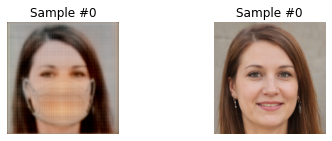

[Epoch 2/10] [Batch 1/180] [D loss: 0.542092] [G loss: 0.921612]
[Epoch 2/10] [Batch 2/180] [D loss: 0.643696] [G loss: 1.028233]
[Epoch 2/10] [Batch 3/180] [D loss: 0.622850] [G loss: 0.770451]
[Epoch 2/10] [Batch 4/180] [D loss: 0.622948] [G loss: 1.035723]
[Epoch 2/10] [Batch 5/180] [D loss: 0.501171] [G loss: 1.011791]
[Epoch 2/10] [Batch 6/180] [D loss: 0.489054] [G loss: 1.001294]
[Epoch 2/10] [Batch 7/180] [D loss: 0.472867] [G loss: 1.015965]
[Epoch 2/10] [Batch 8/180] [D loss: 0.471566] [G loss: 1.015529]
[Epoch 2/10] [Batch 9/180] [D loss: 0.471818] [G loss: 1.017859]
[Epoch 2/10] [Batch 10/180] [D loss: 0.465155] [G loss: 1.018663]
[Epoch 2/10] [Batch 11/180] [D loss: 0.461584] [G loss: 1.023299]
[Epoch 2/10] [Batch 12/180] [D loss: 0.455943] [G loss: 1.024226]
[Epoch 2/10] [Batch 13/180] [D loss: 0.459381] [G loss: 1.034541]
[Epoch 2/10] [Batch 14/180] [D loss: 0.463110] [G loss: 1.026541]
[Epoch 2/10] [Batch 15/180] [D loss: 0.457481] [G loss: 1.017832]
[Epoch 2/10] [Batch

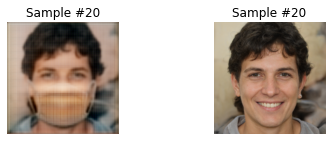

[Epoch 2/10] [Batch 21/180] [D loss: 0.699827] [G loss: 1.069651]
[Epoch 2/10] [Batch 22/180] [D loss: 0.686908] [G loss: 1.050373]
[Epoch 2/10] [Batch 23/180] [D loss: 0.628143] [G loss: 0.978096]
[Epoch 2/10] [Batch 24/180] [D loss: 0.565398] [G loss: 0.860365]
[Epoch 2/10] [Batch 25/180] [D loss: 0.678670] [G loss: 0.585826]
[Epoch 2/10] [Batch 26/180] [D loss: 0.614336] [G loss: 0.788091]
[Epoch 2/10] [Batch 27/180] [D loss: 0.665647] [G loss: 0.963025]
[Epoch 2/10] [Batch 28/180] [D loss: 0.585073] [G loss: 0.954582]
[Epoch 2/10] [Batch 29/180] [D loss: 0.575034] [G loss: 0.823948]
[Epoch 2/10] [Batch 30/180] [D loss: 0.586683] [G loss: 0.924898]
[Epoch 2/10] [Batch 31/180] [D loss: 0.473133] [G loss: 1.031534]
[Epoch 2/10] [Batch 32/180] [D loss: 0.518644] [G loss: 0.906550]
[Epoch 2/10] [Batch 33/180] [D loss: 0.482944] [G loss: 1.002284]
[Epoch 2/10] [Batch 34/180] [D loss: 0.465848] [G loss: 1.058368]
[Epoch 2/10] [Batch 35/180] [D loss: 0.459906] [G loss: 1.066811]
[Epoch 2/1

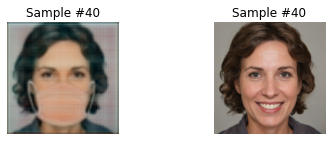

[Epoch 2/10] [Batch 41/180] [D loss: 0.428682] [G loss: 1.073939]
[Epoch 2/10] [Batch 42/180] [D loss: 0.429013] [G loss: 1.083611]
[Epoch 2/10] [Batch 43/180] [D loss: 0.431125] [G loss: 1.065558]
[Epoch 2/10] [Batch 44/180] [D loss: 0.431854] [G loss: 1.066407]
[Epoch 2/10] [Batch 45/180] [D loss: 0.432231] [G loss: 1.079903]
[Epoch 2/10] [Batch 46/180] [D loss: 0.429255] [G loss: 1.090056]
[Epoch 2/10] [Batch 47/180] [D loss: 0.417996] [G loss: 1.082797]
[Epoch 2/10] [Batch 48/180] [D loss: 0.425799] [G loss: 1.074425]
[Epoch 2/10] [Batch 49/180] [D loss: 0.417280] [G loss: 1.086701]
[Epoch 2/10] [Batch 50/180] [D loss: 0.415872] [G loss: 1.082663]
[Epoch 2/10] [Batch 51/180] [D loss: 0.425425] [G loss: 1.076409]
[Epoch 2/10] [Batch 52/180] [D loss: 0.552907] [G loss: 0.828021]
[Epoch 2/10] [Batch 53/180] [D loss: 0.539740] [G loss: 1.144140]
[Epoch 2/10] [Batch 54/180] [D loss: 0.465645] [G loss: 1.137048]
[Epoch 2/10] [Batch 55/180] [D loss: 0.464080] [G loss: 1.096761]
[Epoch 2/1

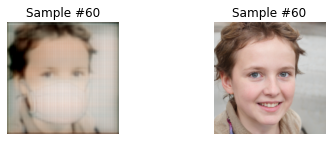

[Epoch 2/10] [Batch 61/180] [D loss: 0.402749] [G loss: 1.171695]
[Epoch 2/10] [Batch 62/180] [D loss: 0.415921] [G loss: 1.179350]
[Epoch 2/10] [Batch 63/180] [D loss: 0.392094] [G loss: 1.159885]
[Epoch 2/10] [Batch 64/180] [D loss: 0.400080] [G loss: 1.150061]
[Epoch 2/10] [Batch 65/180] [D loss: 0.400034] [G loss: 1.151936]
[Epoch 2/10] [Batch 66/180] [D loss: 0.396127] [G loss: 1.156662]
[Epoch 2/10] [Batch 67/180] [D loss: 0.386400] [G loss: 1.163285]
[Epoch 2/10] [Batch 68/180] [D loss: 0.387954] [G loss: 1.155048]
[Epoch 2/10] [Batch 69/180] [D loss: 0.387284] [G loss: 1.160485]
[Epoch 2/10] [Batch 70/180] [D loss: 0.380813] [G loss: 1.157368]
[Epoch 2/10] [Batch 71/180] [D loss: 0.380899] [G loss: 1.154467]
[Epoch 2/10] [Batch 72/180] [D loss: 0.374024] [G loss: 1.165087]
[Epoch 2/10] [Batch 73/180] [D loss: 0.371641] [G loss: 1.164764]
[Epoch 2/10] [Batch 74/180] [D loss: 0.380666] [G loss: 1.167690]
[Epoch 2/10] [Batch 75/180] [D loss: 0.377970] [G loss: 1.165397]
[Epoch 2/1

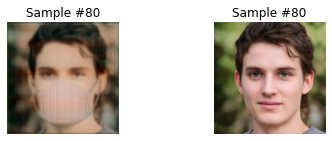

[Epoch 2/10] [Batch 81/180] [D loss: 0.372278] [G loss: 1.185068]
[Epoch 2/10] [Batch 82/180] [D loss: 0.359702] [G loss: 1.184087]
[Epoch 2/10] [Batch 83/180] [D loss: 0.374099] [G loss: 1.185972]
[Epoch 2/10] [Batch 84/180] [D loss: 0.361221] [G loss: 1.183804]
[Epoch 2/10] [Batch 85/180] [D loss: 0.366318] [G loss: 1.140087]
[Epoch 2/10] [Batch 86/180] [D loss: 0.389401] [G loss: 1.132426]
[Epoch 2/10] [Batch 87/180] [D loss: 0.362748] [G loss: 1.187768]
[Epoch 2/10] [Batch 88/180] [D loss: 0.368987] [G loss: 1.159762]
[Epoch 2/10] [Batch 89/180] [D loss: 0.354945] [G loss: 1.191277]
[Epoch 2/10] [Batch 90/180] [D loss: 0.363247] [G loss: 1.197278]
[Epoch 2/10] [Batch 91/180] [D loss: 0.358541] [G loss: 1.196365]
[Epoch 2/10] [Batch 92/180] [D loss: 0.452993] [G loss: 0.971388]
[Epoch 2/10] [Batch 93/180] [D loss: 0.510519] [G loss: 1.354192]
[Epoch 2/10] [Batch 94/180] [D loss: 0.385533] [G loss: 1.340364]
[Epoch 2/10] [Batch 95/180] [D loss: 0.367543] [G loss: 1.364288]
[Epoch 2/1

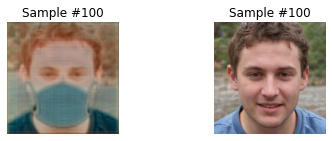

[Epoch 2/10] [Batch 101/180] [D loss: 0.355668] [G loss: 1.297375]
[Epoch 2/10] [Batch 102/180] [D loss: 0.347708] [G loss: 1.288377]
[Epoch 2/10] [Batch 103/180] [D loss: 0.337420] [G loss: 1.292105]
[Epoch 2/10] [Batch 104/180] [D loss: 0.340173] [G loss: 1.289206]
[Epoch 2/10] [Batch 105/180] [D loss: 0.330367] [G loss: 1.282515]
[Epoch 2/10] [Batch 106/180] [D loss: 0.334618] [G loss: 1.287651]
[Epoch 2/10] [Batch 107/180] [D loss: 0.338494] [G loss: 1.281603]
[Epoch 2/10] [Batch 108/180] [D loss: 0.326313] [G loss: 1.285266]
[Epoch 2/10] [Batch 109/180] [D loss: 0.335095] [G loss: 1.282990]
[Epoch 2/10] [Batch 110/180] [D loss: 0.329689] [G loss: 1.275651]
[Epoch 2/10] [Batch 111/180] [D loss: 0.322601] [G loss: 1.278023]
[Epoch 2/10] [Batch 112/180] [D loss: 0.334494] [G loss: 1.286355]
[Epoch 2/10] [Batch 113/180] [D loss: 0.327914] [G loss: 1.273991]
[Epoch 2/10] [Batch 114/180] [D loss: 0.331781] [G loss: 1.272443]
[Epoch 2/10] [Batch 115/180] [D loss: 0.355653] [G loss: 1.203

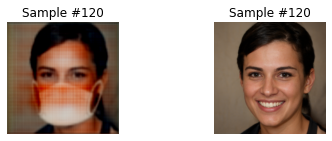

[Epoch 2/10] [Batch 121/180] [D loss: 0.320604] [G loss: 1.290535]
[Epoch 2/10] [Batch 122/180] [D loss: 0.316028] [G loss: 1.297217]
[Epoch 2/10] [Batch 123/180] [D loss: 0.315545] [G loss: 1.296862]
[Epoch 2/10] [Batch 124/180] [D loss: 0.317451] [G loss: 1.294525]
[Epoch 2/10] [Batch 125/180] [D loss: 0.312201] [G loss: 1.297678]
[Epoch 2/10] [Batch 126/180] [D loss: 0.310947] [G loss: 1.306447]
[Epoch 2/10] [Batch 127/180] [D loss: 0.310464] [G loss: 1.314599]
[Epoch 2/10] [Batch 128/180] [D loss: 0.303839] [G loss: 1.317441]
[Epoch 2/10] [Batch 129/180] [D loss: 0.300010] [G loss: 1.323812]
[Epoch 2/10] [Batch 130/180] [D loss: 0.299719] [G loss: 1.322579]
[Epoch 2/10] [Batch 131/180] [D loss: 0.301577] [G loss: 1.330060]
[Epoch 2/10] [Batch 132/180] [D loss: 0.317865] [G loss: 1.341506]
[Epoch 2/10] [Batch 133/180] [D loss: 0.302245] [G loss: 1.332027]
[Epoch 2/10] [Batch 134/180] [D loss: 0.302476] [G loss: 1.321492]
[Epoch 2/10] [Batch 135/180] [D loss: 0.303237] [G loss: 1.316

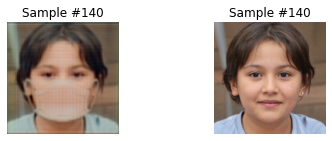

[Epoch 2/10] [Batch 141/180] [D loss: 0.291473] [G loss: 1.367998]
[Epoch 2/10] [Batch 142/180] [D loss: 0.284509] [G loss: 1.370689]
[Epoch 2/10] [Batch 143/180] [D loss: 0.284639] [G loss: 1.375018]
[Epoch 2/10] [Batch 144/180] [D loss: 0.304452] [G loss: 1.348244]
[Epoch 2/10] [Batch 145/180] [D loss: 0.294867] [G loss: 1.346809]
[Epoch 2/10] [Batch 146/180] [D loss: 0.288572] [G loss: 1.380940]
[Epoch 2/10] [Batch 147/180] [D loss: 0.304307] [G loss: 1.332425]
[Epoch 2/10] [Batch 148/180] [D loss: 0.333958] [G loss: 1.368150]
[Epoch 2/10] [Batch 149/180] [D loss: 0.306396] [G loss: 1.323068]
[Epoch 2/10] [Batch 150/180] [D loss: 0.307957] [G loss: 1.351153]
[Epoch 2/10] [Batch 151/180] [D loss: 0.284488] [G loss: 1.413117]
[Epoch 2/10] [Batch 152/180] [D loss: 0.290240] [G loss: 1.419137]
[Epoch 2/10] [Batch 153/180] [D loss: 0.273859] [G loss: 1.420535]
[Epoch 2/10] [Batch 154/180] [D loss: 0.279610] [G loss: 1.427121]
[Epoch 2/10] [Batch 155/180] [D loss: 0.275179] [G loss: 1.428

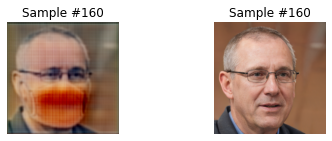

[Epoch 2/10] [Batch 161/180] [D loss: 0.671954] [G loss: 0.907618]
[Epoch 2/10] [Batch 162/180] [D loss: 0.607595] [G loss: 1.006105]
[Epoch 2/10] [Batch 163/180] [D loss: 0.620294] [G loss: 0.982860]
[Epoch 2/10] [Batch 164/180] [D loss: 0.494522] [G loss: 1.075727]
[Epoch 2/10] [Batch 165/180] [D loss: 0.483058] [G loss: 1.184390]
[Epoch 2/10] [Batch 166/180] [D loss: 0.478770] [G loss: 1.126442]
[Epoch 2/10] [Batch 167/180] [D loss: 0.533110] [G loss: 0.876852]
[Epoch 2/10] [Batch 168/180] [D loss: 0.571500] [G loss: 1.065434]
[Epoch 2/10] [Batch 169/180] [D loss: 0.524346] [G loss: 1.182228]
[Epoch 2/10] [Batch 170/180] [D loss: 0.538071] [G loss: 0.922579]
[Epoch 2/10] [Batch 171/180] [D loss: 0.425840] [G loss: 1.263526]
[Epoch 2/10] [Batch 172/180] [D loss: 0.429506] [G loss: 1.096337]
[Epoch 2/10] [Batch 173/180] [D loss: 0.419041] [G loss: 1.113112]
[Epoch 2/10] [Batch 174/180] [D loss: 0.388859] [G loss: 1.280322]
[Epoch 2/10] [Batch 175/180] [D loss: 0.525707] [G loss: 0.877

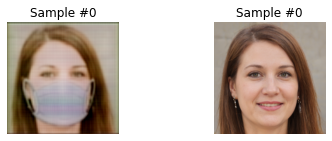

[Epoch 3/10] [Batch 1/180] [D loss: 0.319226] [G loss: 1.268413]
[Epoch 3/10] [Batch 2/180] [D loss: 0.328707] [G loss: 1.289277]
[Epoch 3/10] [Batch 3/180] [D loss: 0.321984] [G loss: 1.303214]
[Epoch 3/10] [Batch 4/180] [D loss: 0.330051] [G loss: 1.241356]
[Epoch 3/10] [Batch 5/180] [D loss: 0.307493] [G loss: 1.333044]
[Epoch 3/10] [Batch 6/180] [D loss: 0.295999] [G loss: 1.378077]
[Epoch 3/10] [Batch 7/180] [D loss: 0.321384] [G loss: 1.395653]
[Epoch 3/10] [Batch 8/180] [D loss: 0.286253] [G loss: 1.379848]
[Epoch 3/10] [Batch 9/180] [D loss: 0.300064] [G loss: 1.327000]
[Epoch 3/10] [Batch 10/180] [D loss: 0.309235] [G loss: 1.357454]
[Epoch 3/10] [Batch 11/180] [D loss: 0.325628] [G loss: 1.355585]
[Epoch 3/10] [Batch 12/180] [D loss: 0.288862] [G loss: 1.349228]
[Epoch 3/10] [Batch 13/180] [D loss: 0.291718] [G loss: 1.383024]
[Epoch 3/10] [Batch 14/180] [D loss: 0.302136] [G loss: 1.403237]
[Epoch 3/10] [Batch 15/180] [D loss: 0.321359] [G loss: 1.403073]
[Epoch 3/10] [Batch

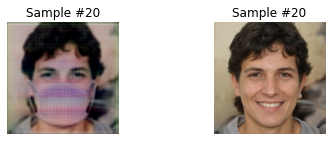

[Epoch 3/10] [Batch 21/180] [D loss: 0.274550] [G loss: 1.433692]
[Epoch 3/10] [Batch 22/180] [D loss: 0.272368] [G loss: 1.433473]
[Epoch 3/10] [Batch 23/180] [D loss: 0.274422] [G loss: 1.430930]
[Epoch 3/10] [Batch 24/180] [D loss: 0.340346] [G loss: 1.226912]
[Epoch 3/10] [Batch 25/180] [D loss: 0.518282] [G loss: 1.429422]
[Epoch 3/10] [Batch 26/180] [D loss: 0.546208] [G loss: 0.745468]
[Epoch 3/10] [Batch 27/180] [D loss: 0.460555] [G loss: 1.185682]
[Epoch 3/10] [Batch 28/180] [D loss: 0.501643] [G loss: 1.420480]
[Epoch 3/10] [Batch 29/180] [D loss: 0.353272] [G loss: 1.231546]
[Epoch 3/10] [Batch 30/180] [D loss: 0.326734] [G loss: 1.360963]
[Epoch 3/10] [Batch 31/180] [D loss: 0.331328] [G loss: 1.264359]
[Epoch 3/10] [Batch 32/180] [D loss: 0.315574] [G loss: 1.400497]
[Epoch 3/10] [Batch 33/180] [D loss: 0.366509] [G loss: 1.432941]
[Epoch 3/10] [Batch 34/180] [D loss: 0.341824] [G loss: 1.322711]
[Epoch 3/10] [Batch 35/180] [D loss: 0.512994] [G loss: 0.945524]
[Epoch 3/1

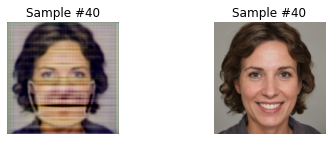

[Epoch 3/10] [Batch 41/180] [D loss: 0.329582] [G loss: 1.199080]
[Epoch 3/10] [Batch 42/180] [D loss: 0.292879] [G loss: 1.345368]
[Epoch 3/10] [Batch 43/180] [D loss: 0.297867] [G loss: 1.394102]
[Epoch 3/10] [Batch 44/180] [D loss: 0.283287] [G loss: 1.403063]
[Epoch 3/10] [Batch 45/180] [D loss: 0.276305] [G loss: 1.407307]
[Epoch 3/10] [Batch 46/180] [D loss: 0.280930] [G loss: 1.414143]
[Epoch 3/10] [Batch 47/180] [D loss: 0.332984] [G loss: 1.374736]
[Epoch 3/10] [Batch 48/180] [D loss: 0.576529] [G loss: 0.771149]
[Epoch 3/10] [Batch 49/180] [D loss: 0.692862] [G loss: 1.426235]
[Epoch 3/10] [Batch 50/180] [D loss: 0.989608] [G loss: 0.571979]
[Epoch 3/10] [Batch 51/180] [D loss: 0.811429] [G loss: 0.488789]
[Epoch 3/10] [Batch 52/180] [D loss: 0.336027] [G loss: 1.237231]
[Epoch 3/10] [Batch 53/180] [D loss: 0.297826] [G loss: 1.470475]
[Epoch 3/10] [Batch 54/180] [D loss: 0.314379] [G loss: 1.512498]
[Epoch 3/10] [Batch 55/180] [D loss: 0.351079] [G loss: 1.246682]
[Epoch 3/1

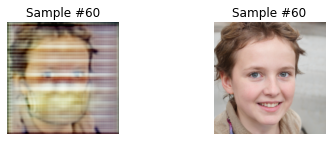

[Epoch 3/10] [Batch 61/180] [D loss: 0.285505] [G loss: 1.417006]
[Epoch 3/10] [Batch 62/180] [D loss: 0.286342] [G loss: 1.459559]
[Epoch 3/10] [Batch 63/180] [D loss: 0.291041] [G loss: 1.541750]
[Epoch 3/10] [Batch 64/180] [D loss: 0.289697] [G loss: 1.463617]
[Epoch 3/10] [Batch 65/180] [D loss: 0.444333] [G loss: 0.964270]
[Epoch 3/10] [Batch 66/180] [D loss: 0.870605] [G loss: 1.621585]
[Epoch 3/10] [Batch 67/180] [D loss: 0.856654] [G loss: 1.617991]
[Epoch 3/10] [Batch 68/180] [D loss: 0.830347] [G loss: 1.555057]
[Epoch 3/10] [Batch 69/180] [D loss: 0.777182] [G loss: 1.470570]
[Epoch 3/10] [Batch 70/180] [D loss: 0.684292] [G loss: 1.341083]
[Epoch 3/10] [Batch 71/180] [D loss: 0.615414] [G loss: 1.065896]
[Epoch 3/10] [Batch 72/180] [D loss: 0.577303] [G loss: 1.104911]
[Epoch 3/10] [Batch 73/180] [D loss: 0.520693] [G loss: 1.044261]
[Epoch 3/10] [Batch 74/180] [D loss: 0.514171] [G loss: 1.023520]
[Epoch 3/10] [Batch 75/180] [D loss: 0.492082] [G loss: 1.004081]
[Epoch 3/1

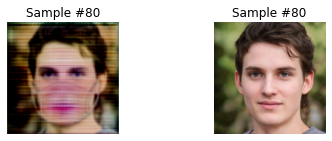

[Epoch 3/10] [Batch 81/180] [D loss: 0.398987] [G loss: 1.101372]
[Epoch 3/10] [Batch 82/180] [D loss: 0.433029] [G loss: 1.186071]
[Epoch 3/10] [Batch 83/180] [D loss: 0.404589] [G loss: 1.149562]
[Epoch 3/10] [Batch 84/180] [D loss: 0.422189] [G loss: 1.130252]
[Epoch 3/10] [Batch 85/180] [D loss: 0.444219] [G loss: 1.086483]
[Epoch 3/10] [Batch 86/180] [D loss: 0.480614] [G loss: 1.172930]
[Epoch 3/10] [Batch 87/180] [D loss: 0.759896] [G loss: 0.561737]
[Epoch 3/10] [Batch 88/180] [D loss: 0.770190] [G loss: 0.683918]
[Epoch 3/10] [Batch 89/180] [D loss: 0.579040] [G loss: 1.052037]
[Epoch 3/10] [Batch 90/180] [D loss: 0.506653] [G loss: 1.136530]
[Epoch 3/10] [Batch 91/180] [D loss: 0.579303] [G loss: 0.882301]
[Epoch 3/10] [Batch 92/180] [D loss: 0.695461] [G loss: 1.259464]
[Epoch 3/10] [Batch 93/180] [D loss: 0.575742] [G loss: 1.042669]
[Epoch 3/10] [Batch 94/180] [D loss: 0.739486] [G loss: 0.572949]
[Epoch 3/10] [Batch 95/180] [D loss: 0.580010] [G loss: 0.960031]
[Epoch 3/1

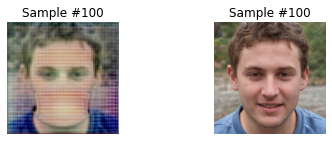

[Epoch 3/10] [Batch 101/180] [D loss: 0.598401] [G loss: 0.846632]
[Epoch 3/10] [Batch 102/180] [D loss: 0.649232] [G loss: 1.325253]
[Epoch 3/10] [Batch 103/180] [D loss: 0.554007] [G loss: 0.833495]
[Epoch 3/10] [Batch 104/180] [D loss: 0.530968] [G loss: 1.174200]
[Epoch 3/10] [Batch 105/180] [D loss: 0.563666] [G loss: 0.883931]
[Epoch 3/10] [Batch 106/180] [D loss: 0.528057] [G loss: 1.125768]
[Epoch 3/10] [Batch 107/180] [D loss: 0.466465] [G loss: 1.129632]
[Epoch 3/10] [Batch 108/180] [D loss: 0.506900] [G loss: 0.992977]
[Epoch 3/10] [Batch 109/180] [D loss: 0.554409] [G loss: 1.164195]
[Epoch 3/10] [Batch 110/180] [D loss: 0.453443] [G loss: 1.039641]
[Epoch 3/10] [Batch 111/180] [D loss: 0.491360] [G loss: 1.148978]
[Epoch 3/10] [Batch 112/180] [D loss: 0.577130] [G loss: 0.783226]
[Epoch 3/10] [Batch 113/180] [D loss: 0.552709] [G loss: 1.206657]
[Epoch 3/10] [Batch 114/180] [D loss: 0.480686] [G loss: 1.204118]
[Epoch 3/10] [Batch 115/180] [D loss: 0.443477] [G loss: 1.009

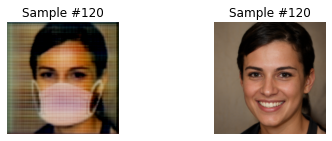

[Epoch 3/10] [Batch 121/180] [D loss: 0.352782] [G loss: 1.258163]
[Epoch 3/10] [Batch 122/180] [D loss: 0.347083] [G loss: 1.289728]
[Epoch 3/10] [Batch 123/180] [D loss: 0.352357] [G loss: 1.238073]
[Epoch 3/10] [Batch 124/180] [D loss: 0.429038] [G loss: 1.159520]
[Epoch 3/10] [Batch 125/180] [D loss: 0.548565] [G loss: 0.728538]
[Epoch 3/10] [Batch 126/180] [D loss: 0.530971] [G loss: 1.429032]
[Epoch 3/10] [Batch 127/180] [D loss: 0.391907] [G loss: 1.145583]
[Epoch 3/10] [Batch 128/180] [D loss: 0.417322] [G loss: 1.027329]
[Epoch 3/10] [Batch 129/180] [D loss: 0.391272] [G loss: 1.355322]
[Epoch 3/10] [Batch 130/180] [D loss: 0.355743] [G loss: 1.301510]
[Epoch 3/10] [Batch 131/180] [D loss: 0.400524] [G loss: 1.056531]
[Epoch 3/10] [Batch 132/180] [D loss: 0.435224] [G loss: 1.004426]
[Epoch 3/10] [Batch 133/180] [D loss: 0.542412] [G loss: 1.303360]
[Epoch 3/10] [Batch 134/180] [D loss: 0.603216] [G loss: 0.854312]
[Epoch 3/10] [Batch 135/180] [D loss: 0.589635] [G loss: 1.273

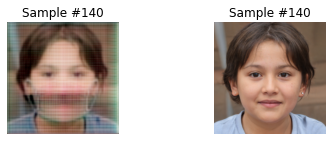

[Epoch 3/10] [Batch 141/180] [D loss: 0.636067] [G loss: 0.949194]
[Epoch 3/10] [Batch 142/180] [D loss: 0.396339] [G loss: 1.212105]
[Epoch 3/10] [Batch 143/180] [D loss: 0.390888] [G loss: 1.131855]
[Epoch 3/10] [Batch 144/180] [D loss: 0.345712] [G loss: 1.300210]
[Epoch 3/10] [Batch 145/180] [D loss: 0.368676] [G loss: 1.195491]
[Epoch 3/10] [Batch 146/180] [D loss: 0.358204] [G loss: 1.302458]
[Epoch 3/10] [Batch 147/180] [D loss: 0.344895] [G loss: 1.304028]
[Epoch 3/10] [Batch 148/180] [D loss: 0.313706] [G loss: 1.437796]
[Epoch 3/10] [Batch 149/180] [D loss: 0.303582] [G loss: 1.472566]
[Epoch 3/10] [Batch 150/180] [D loss: 0.381645] [G loss: 1.128585]
[Epoch 3/10] [Batch 151/180] [D loss: 0.500948] [G loss: 1.365362]
[Epoch 3/10] [Batch 152/180] [D loss: 0.372719] [G loss: 1.174781]
[Epoch 3/10] [Batch 153/180] [D loss: 0.339022] [G loss: 1.326602]
[Epoch 3/10] [Batch 154/180] [D loss: 0.370464] [G loss: 1.152389]
[Epoch 3/10] [Batch 155/180] [D loss: 0.672806] [G loss: 1.410

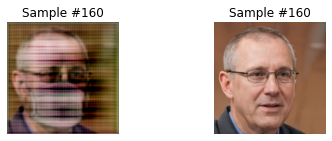

[Epoch 3/10] [Batch 161/180] [D loss: 0.387398] [G loss: 1.061831]
[Epoch 3/10] [Batch 162/180] [D loss: 0.373072] [G loss: 1.375938]
[Epoch 3/10] [Batch 163/180] [D loss: 0.331511] [G loss: 1.377212]
[Epoch 3/10] [Batch 164/180] [D loss: 0.294568] [G loss: 1.460470]
[Epoch 3/10] [Batch 165/180] [D loss: 0.301109] [G loss: 1.452274]
[Epoch 3/10] [Batch 166/180] [D loss: 0.308056] [G loss: 1.401609]
[Epoch 3/10] [Batch 167/180] [D loss: 0.526970] [G loss: 0.814435]
[Epoch 3/10] [Batch 168/180] [D loss: 0.767795] [G loss: 1.483191]
[Epoch 3/10] [Batch 169/180] [D loss: 0.718606] [G loss: 1.380518]
[Epoch 3/10] [Batch 170/180] [D loss: 0.625073] [G loss: 1.044367]
[Epoch 3/10] [Batch 171/180] [D loss: 0.677053] [G loss: 0.663592]
[Epoch 3/10] [Batch 172/180] [D loss: 0.618602] [G loss: 1.286592]
[Epoch 3/10] [Batch 173/180] [D loss: 0.468702] [G loss: 1.089062]
[Epoch 3/10] [Batch 174/180] [D loss: 0.679379] [G loss: 0.607993]
[Epoch 3/10] [Batch 175/180] [D loss: 0.574040] [G loss: 1.269

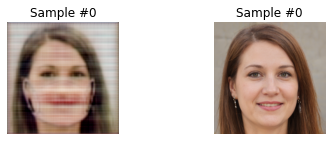

[Epoch 4/10] [Batch 1/180] [D loss: 0.692843] [G loss: 0.539883]
[Epoch 4/10] [Batch 2/180] [D loss: 0.743769] [G loss: 1.249613]
[Epoch 4/10] [Batch 3/180] [D loss: 0.626497] [G loss: 1.196498]
[Epoch 4/10] [Batch 4/180] [D loss: 0.395895] [G loss: 1.227066]
[Epoch 4/10] [Batch 5/180] [D loss: 0.314735] [G loss: 1.327218]
[Epoch 4/10] [Batch 6/180] [D loss: 0.442491] [G loss: 0.948932]
[Epoch 4/10] [Batch 7/180] [D loss: 0.503514] [G loss: 1.112614]
[Epoch 4/10] [Batch 8/180] [D loss: 0.353568] [G loss: 1.258603]
[Epoch 4/10] [Batch 9/180] [D loss: 0.287049] [G loss: 1.402521]
[Epoch 4/10] [Batch 10/180] [D loss: 0.291459] [G loss: 1.396315]
[Epoch 4/10] [Batch 11/180] [D loss: 0.265815] [G loss: 1.439026]
[Epoch 4/10] [Batch 12/180] [D loss: 0.282956] [G loss: 1.431048]
[Epoch 4/10] [Batch 13/180] [D loss: 0.278162] [G loss: 1.446255]
[Epoch 4/10] [Batch 14/180] [D loss: 0.252958] [G loss: 1.477953]
[Epoch 4/10] [Batch 15/180] [D loss: 0.253117] [G loss: 1.502605]
[Epoch 4/10] [Batch

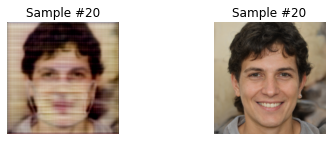

[Epoch 4/10] [Batch 21/180] [D loss: 0.259426] [G loss: 1.408733]
[Epoch 4/10] [Batch 22/180] [D loss: 0.281347] [G loss: 1.377180]
[Epoch 4/10] [Batch 23/180] [D loss: 0.331656] [G loss: 1.126975]
[Epoch 4/10] [Batch 24/180] [D loss: 0.719944] [G loss: 1.593819]
[Epoch 4/10] [Batch 25/180] [D loss: 0.382657] [G loss: 1.484668]
[Epoch 4/10] [Batch 26/180] [D loss: 0.387148] [G loss: 0.933560]
[Epoch 4/10] [Batch 27/180] [D loss: 0.288019] [G loss: 1.444921]
[Epoch 4/10] [Batch 28/180] [D loss: 0.328683] [G loss: 1.422940]
[Epoch 4/10] [Batch 29/180] [D loss: 0.307892] [G loss: 1.162041]
[Epoch 4/10] [Batch 30/180] [D loss: 0.423666] [G loss: 0.872934]
[Epoch 4/10] [Batch 31/180] [D loss: 0.792248] [G loss: 1.496954]
[Epoch 4/10] [Batch 32/180] [D loss: 0.797701] [G loss: 1.478062]
[Epoch 4/10] [Batch 33/180] [D loss: 0.704427] [G loss: 1.382179]
[Epoch 4/10] [Batch 34/180] [D loss: 0.620865] [G loss: 1.186518]
[Epoch 4/10] [Batch 35/180] [D loss: 0.604342] [G loss: 0.952130]
[Epoch 4/1

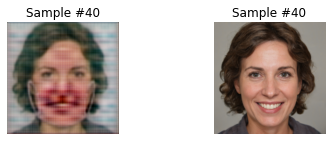

[Epoch 4/10] [Batch 41/180] [D loss: 0.463856] [G loss: 1.145778]
[Epoch 4/10] [Batch 42/180] [D loss: 0.502946] [G loss: 0.967809]
[Epoch 4/10] [Batch 43/180] [D loss: 0.594472] [G loss: 0.789544]
[Epoch 4/10] [Batch 44/180] [D loss: 0.476451] [G loss: 1.172896]
[Epoch 4/10] [Batch 45/180] [D loss: 0.455616] [G loss: 1.053395]
[Epoch 4/10] [Batch 46/180] [D loss: 0.433457] [G loss: 0.989672]
[Epoch 4/10] [Batch 47/180] [D loss: 0.493038] [G loss: 0.977794]
[Epoch 4/10] [Batch 48/180] [D loss: 0.465151] [G loss: 1.004350]
[Epoch 4/10] [Batch 49/180] [D loss: 0.381998] [G loss: 1.228404]
[Epoch 4/10] [Batch 50/180] [D loss: 0.364658] [G loss: 1.186530]
[Epoch 4/10] [Batch 51/180] [D loss: 0.338715] [G loss: 1.283203]
[Epoch 4/10] [Batch 52/180] [D loss: 0.317157] [G loss: 1.340984]
[Epoch 4/10] [Batch 53/180] [D loss: 0.328510] [G loss: 1.313043]
[Epoch 4/10] [Batch 54/180] [D loss: 0.327184] [G loss: 1.232641]
[Epoch 4/10] [Batch 55/180] [D loss: 0.341916] [G loss: 1.202465]
[Epoch 4/1

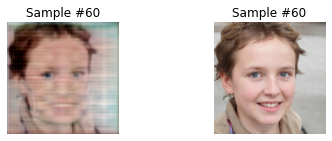

[Epoch 4/10] [Batch 61/180] [D loss: 0.571095] [G loss: 0.935222]
[Epoch 4/10] [Batch 62/180] [D loss: 0.692778] [G loss: 0.939439]
[Epoch 4/10] [Batch 63/180] [D loss: 0.473559] [G loss: 1.092374]
[Epoch 4/10] [Batch 64/180] [D loss: 0.539976] [G loss: 0.945984]
[Epoch 4/10] [Batch 65/180] [D loss: 0.695148] [G loss: 0.652367]
[Epoch 4/10] [Batch 66/180] [D loss: 0.617579] [G loss: 0.969586]
[Epoch 4/10] [Batch 67/180] [D loss: 0.525196] [G loss: 1.193382]
[Epoch 4/10] [Batch 68/180] [D loss: 0.445169] [G loss: 1.142599]
[Epoch 4/10] [Batch 69/180] [D loss: 0.450117] [G loss: 0.937372]
[Epoch 4/10] [Batch 70/180] [D loss: 0.422007] [G loss: 1.141536]
[Epoch 4/10] [Batch 71/180] [D loss: 0.425990] [G loss: 1.047148]
[Epoch 4/10] [Batch 72/180] [D loss: 0.411480] [G loss: 1.042093]
[Epoch 4/10] [Batch 73/180] [D loss: 0.388927] [G loss: 1.267054]
[Epoch 4/10] [Batch 74/180] [D loss: 0.523347] [G loss: 0.744195]
[Epoch 4/10] [Batch 75/180] [D loss: 0.735445] [G loss: 1.582054]
[Epoch 4/1

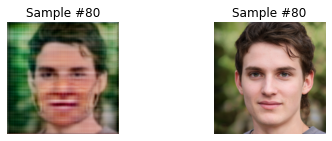

[Epoch 4/10] [Batch 81/180] [D loss: 0.276647] [G loss: 1.402402]
[Epoch 4/10] [Batch 82/180] [D loss: 0.269882] [G loss: 1.329379]
[Epoch 4/10] [Batch 83/180] [D loss: 0.278541] [G loss: 1.383011]
[Epoch 4/10] [Batch 84/180] [D loss: 0.241873] [G loss: 1.374335]
[Epoch 4/10] [Batch 85/180] [D loss: 0.245268] [G loss: 1.430082]
[Epoch 4/10] [Batch 86/180] [D loss: 0.268780] [G loss: 1.336655]
[Epoch 4/10] [Batch 87/180] [D loss: 0.356140] [G loss: 1.398019]
[Epoch 4/10] [Batch 88/180] [D loss: 0.733096] [G loss: 0.560666]
[Epoch 4/10] [Batch 89/180] [D loss: 0.860906] [G loss: 1.568287]
[Epoch 4/10] [Batch 90/180] [D loss: 0.809430] [G loss: 1.496252]
[Epoch 4/10] [Batch 91/180] [D loss: 0.774782] [G loss: 1.312015]
[Epoch 4/10] [Batch 92/180] [D loss: 0.721247] [G loss: 1.062833]
[Epoch 4/10] [Batch 93/180] [D loss: 0.669600] [G loss: 0.945192]
[Epoch 4/10] [Batch 94/180] [D loss: 0.664397] [G loss: 0.956648]
[Epoch 4/10] [Batch 95/180] [D loss: 0.577295] [G loss: 1.105783]
[Epoch 4/1

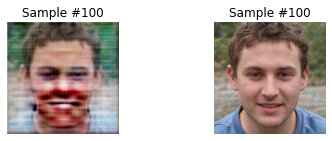

[Epoch 4/10] [Batch 101/180] [D loss: 0.652356] [G loss: 1.065143]
[Epoch 4/10] [Batch 102/180] [D loss: 0.664367] [G loss: 0.979534]
[Epoch 4/10] [Batch 103/180] [D loss: 0.601492] [G loss: 0.977865]
[Epoch 4/10] [Batch 104/180] [D loss: 0.619278] [G loss: 0.854403]
[Epoch 4/10] [Batch 105/180] [D loss: 0.561252] [G loss: 0.963579]
[Epoch 4/10] [Batch 106/180] [D loss: 0.536183] [G loss: 0.991955]
[Epoch 4/10] [Batch 107/180] [D loss: 0.575775] [G loss: 0.919226]
[Epoch 4/10] [Batch 108/180] [D loss: 0.584907] [G loss: 0.971913]
[Epoch 4/10] [Batch 109/180] [D loss: 0.547557] [G loss: 0.983056]
[Epoch 4/10] [Batch 110/180] [D loss: 0.518405] [G loss: 0.981904]
[Epoch 4/10] [Batch 111/180] [D loss: 0.569721] [G loss: 0.847105]
[Epoch 4/10] [Batch 112/180] [D loss: 0.585396] [G loss: 1.063626]
[Epoch 4/10] [Batch 113/180] [D loss: 0.515585] [G loss: 1.000434]
[Epoch 4/10] [Batch 114/180] [D loss: 0.520882] [G loss: 1.059072]
[Epoch 4/10] [Batch 115/180] [D loss: 0.590002] [G loss: 0.837

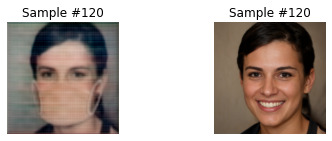

[Epoch 4/10] [Batch 121/180] [D loss: 0.420523] [G loss: 0.969630]
[Epoch 4/10] [Batch 122/180] [D loss: 0.611675] [G loss: 0.652507]
[Epoch 4/10] [Batch 123/180] [D loss: 0.443942] [G loss: 1.272225]
[Epoch 4/10] [Batch 124/180] [D loss: 0.380533] [G loss: 1.155820]
[Epoch 4/10] [Batch 125/180] [D loss: 0.360395] [G loss: 1.265503]
[Epoch 4/10] [Batch 126/180] [D loss: 0.402750] [G loss: 1.028547]
[Epoch 4/10] [Batch 127/180] [D loss: 0.473810] [G loss: 0.934380]
[Epoch 4/10] [Batch 128/180] [D loss: 0.466232] [G loss: 1.396894]
[Epoch 4/10] [Batch 129/180] [D loss: 0.348749] [G loss: 1.284064]
[Epoch 4/10] [Batch 130/180] [D loss: 0.506860] [G loss: 0.813865]
[Epoch 4/10] [Batch 131/180] [D loss: 0.462957] [G loss: 1.184241]
[Epoch 4/10] [Batch 132/180] [D loss: 0.585705] [G loss: 1.016367]
[Epoch 4/10] [Batch 133/180] [D loss: 0.555381] [G loss: 1.004669]
[Epoch 4/10] [Batch 134/180] [D loss: 0.435486] [G loss: 1.254633]
[Epoch 4/10] [Batch 135/180] [D loss: 0.352470] [G loss: 1.304

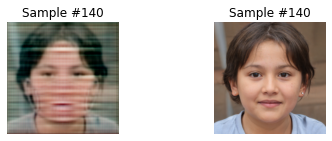

[Epoch 4/10] [Batch 141/180] [D loss: 0.279380] [G loss: 1.283769]
[Epoch 4/10] [Batch 142/180] [D loss: 0.666884] [G loss: 0.603405]
[Epoch 4/10] [Batch 143/180] [D loss: 0.844275] [G loss: 1.657874]
[Epoch 4/10] [Batch 144/180] [D loss: 0.817111] [G loss: 1.623246]
[Epoch 4/10] [Batch 145/180] [D loss: 0.722922] [G loss: 1.473960]
[Epoch 4/10] [Batch 146/180] [D loss: 0.597177] [G loss: 1.227987]
[Epoch 4/10] [Batch 147/180] [D loss: 0.629404] [G loss: 0.918063]
[Epoch 4/10] [Batch 148/180] [D loss: 0.542100] [G loss: 1.099856]
[Epoch 4/10] [Batch 149/180] [D loss: 0.499027] [G loss: 1.232141]
[Epoch 4/10] [Batch 150/180] [D loss: 0.440541] [G loss: 1.277654]
[Epoch 4/10] [Batch 151/180] [D loss: 0.448730] [G loss: 0.935363]
[Epoch 4/10] [Batch 152/180] [D loss: 0.549049] [G loss: 0.989072]
[Epoch 4/10] [Batch 153/180] [D loss: 0.441703] [G loss: 1.123909]
[Epoch 4/10] [Batch 154/180] [D loss: 0.468899] [G loss: 0.907613]
[Epoch 4/10] [Batch 155/180] [D loss: 0.524262] [G loss: 0.816

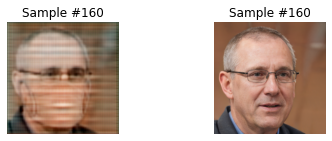

[Epoch 4/10] [Batch 161/180] [D loss: 0.519433] [G loss: 1.167249]
[Epoch 4/10] [Batch 162/180] [D loss: 0.407759] [G loss: 1.009116]
[Epoch 4/10] [Batch 163/180] [D loss: 0.435504] [G loss: 1.098099]
[Epoch 4/10] [Batch 164/180] [D loss: 0.404958] [G loss: 1.033882]
[Epoch 4/10] [Batch 165/180] [D loss: 0.361204] [G loss: 1.328486]
[Epoch 4/10] [Batch 166/180] [D loss: 0.381605] [G loss: 1.044020]
[Epoch 4/10] [Batch 167/180] [D loss: 0.478297] [G loss: 1.383977]
[Epoch 4/10] [Batch 168/180] [D loss: 0.421927] [G loss: 0.963471]
[Epoch 4/10] [Batch 169/180] [D loss: 0.390481] [G loss: 1.339910]
[Epoch 4/10] [Batch 170/180] [D loss: 0.339848] [G loss: 1.134370]
[Epoch 4/10] [Batch 171/180] [D loss: 0.327100] [G loss: 1.401763]
[Epoch 4/10] [Batch 172/180] [D loss: 0.304107] [G loss: 1.381222]
[Epoch 4/10] [Batch 173/180] [D loss: 0.394789] [G loss: 0.928066]
[Epoch 4/10] [Batch 174/180] [D loss: 0.406035] [G loss: 1.492322]
[Epoch 4/10] [Batch 175/180] [D loss: 0.357925] [G loss: 1.102

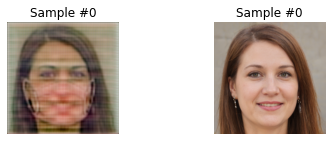

[Epoch 5/10] [Batch 1/180] [D loss: 0.410309] [G loss: 0.966576]
[Epoch 5/10] [Batch 2/180] [D loss: 0.717443] [G loss: 1.415313]
[Epoch 5/10] [Batch 3/180] [D loss: 0.596147] [G loss: 1.219884]
[Epoch 5/10] [Batch 4/180] [D loss: 0.637104] [G loss: 0.632744]
[Epoch 5/10] [Batch 5/180] [D loss: 0.543936] [G loss: 1.147548]
[Epoch 5/10] [Batch 6/180] [D loss: 0.510591] [G loss: 1.143961]
[Epoch 5/10] [Batch 7/180] [D loss: 0.422970] [G loss: 1.198222]
[Epoch 5/10] [Batch 8/180] [D loss: 0.419272] [G loss: 1.124817]
[Epoch 5/10] [Batch 9/180] [D loss: 0.332718] [G loss: 1.420618]
[Epoch 5/10] [Batch 10/180] [D loss: 0.283816] [G loss: 1.447920]
[Epoch 5/10] [Batch 11/180] [D loss: 0.317540] [G loss: 1.204471]
[Epoch 5/10] [Batch 12/180] [D loss: 0.569060] [G loss: 1.565480]
[Epoch 5/10] [Batch 13/180] [D loss: 0.427866] [G loss: 1.315071]
[Epoch 5/10] [Batch 14/180] [D loss: 0.512438] [G loss: 0.813742]
[Epoch 5/10] [Batch 15/180] [D loss: 0.484022] [G loss: 1.436995]
[Epoch 5/10] [Batch

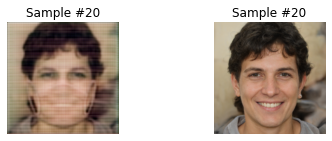

[Epoch 5/10] [Batch 21/180] [D loss: 0.575544] [G loss: 1.262839]
[Epoch 5/10] [Batch 22/180] [D loss: 0.524071] [G loss: 1.084575]
[Epoch 5/10] [Batch 23/180] [D loss: 0.512900] [G loss: 0.995211]
[Epoch 5/10] [Batch 24/180] [D loss: 0.395476] [G loss: 1.426536]
[Epoch 5/10] [Batch 25/180] [D loss: 0.407326] [G loss: 1.334270]
[Epoch 5/10] [Batch 26/180] [D loss: 0.341097] [G loss: 1.429711]
[Epoch 5/10] [Batch 27/180] [D loss: 0.286797] [G loss: 1.440135]
[Epoch 5/10] [Batch 28/180] [D loss: 0.285400] [G loss: 1.429667]
[Epoch 5/10] [Batch 29/180] [D loss: 0.343602] [G loss: 1.214022]
[Epoch 5/10] [Batch 30/180] [D loss: 0.342715] [G loss: 1.445883]
[Epoch 5/10] [Batch 31/180] [D loss: 0.403494] [G loss: 1.123346]
[Epoch 5/10] [Batch 32/180] [D loss: 0.549081] [G loss: 1.548265]
[Epoch 5/10] [Batch 33/180] [D loss: 0.589431] [G loss: 0.637499]
[Epoch 5/10] [Batch 34/180] [D loss: 0.630619] [G loss: 1.335788]
[Epoch 5/10] [Batch 35/180] [D loss: 0.502923] [G loss: 1.334790]
[Epoch 5/1

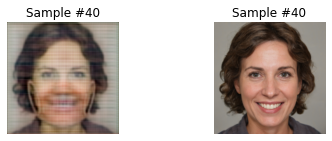

[Epoch 5/10] [Batch 41/180] [D loss: 0.377637] [G loss: 0.999610]
[Epoch 5/10] [Batch 42/180] [D loss: 0.457974] [G loss: 1.540818]
[Epoch 5/10] [Batch 43/180] [D loss: 0.352691] [G loss: 1.109834]
[Epoch 5/10] [Batch 44/180] [D loss: 0.453516] [G loss: 1.512399]
[Epoch 5/10] [Batch 45/180] [D loss: 0.757648] [G loss: 0.530248]
[Epoch 5/10] [Batch 46/180] [D loss: 0.754632] [G loss: 1.564916]
[Epoch 5/10] [Batch 47/180] [D loss: 0.761239] [G loss: 1.502810]
[Epoch 5/10] [Batch 48/180] [D loss: 0.686335] [G loss: 1.336890]
[Epoch 5/10] [Batch 49/180] [D loss: 0.629020] [G loss: 1.187512]
[Epoch 5/10] [Batch 50/180] [D loss: 0.545486] [G loss: 0.992223]
[Epoch 5/10] [Batch 51/180] [D loss: 0.572906] [G loss: 0.960068]
[Epoch 5/10] [Batch 52/180] [D loss: 0.535962] [G loss: 0.947843]
[Epoch 5/10] [Batch 53/180] [D loss: 0.533287] [G loss: 1.216100]
[Epoch 5/10] [Batch 54/180] [D loss: 0.544332] [G loss: 0.984346]
[Epoch 5/10] [Batch 55/180] [D loss: 0.553602] [G loss: 1.000592]
[Epoch 5/1

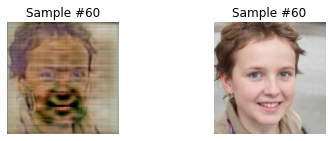

[Epoch 5/10] [Batch 61/180] [D loss: 0.342516] [G loss: 1.157672]
[Epoch 5/10] [Batch 62/180] [D loss: 0.409139] [G loss: 0.948532]
[Epoch 5/10] [Batch 63/180] [D loss: 0.442604] [G loss: 1.378104]
[Epoch 5/10] [Batch 64/180] [D loss: 0.330053] [G loss: 1.239310]
[Epoch 5/10] [Batch 65/180] [D loss: 0.389440] [G loss: 1.019567]
[Epoch 5/10] [Batch 66/180] [D loss: 0.473556] [G loss: 1.142637]
[Epoch 5/10] [Batch 67/180] [D loss: 0.438390] [G loss: 0.927501]
[Epoch 5/10] [Batch 68/180] [D loss: 0.441046] [G loss: 1.496444]
[Epoch 5/10] [Batch 69/180] [D loss: 0.346105] [G loss: 1.075172]
[Epoch 5/10] [Batch 70/180] [D loss: 0.315567] [G loss: 1.210449]
[Epoch 5/10] [Batch 71/180] [D loss: 0.308102] [G loss: 1.310499]
[Epoch 5/10] [Batch 72/180] [D loss: 0.281685] [G loss: 1.488560]
[Epoch 5/10] [Batch 73/180] [D loss: 0.260697] [G loss: 1.491947]
[Epoch 5/10] [Batch 74/180] [D loss: 0.243148] [G loss: 1.524071]
[Epoch 5/10] [Batch 75/180] [D loss: 0.239435] [G loss: 1.520072]
[Epoch 5/1

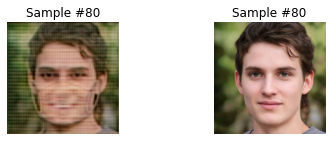

[Epoch 5/10] [Batch 81/180] [D loss: 0.521079] [G loss: 1.541913]
[Epoch 5/10] [Batch 82/180] [D loss: 0.277252] [G loss: 1.448360]
[Epoch 5/10] [Batch 83/180] [D loss: 0.384446] [G loss: 0.993286]
[Epoch 5/10] [Batch 84/180] [D loss: 0.492044] [G loss: 1.044964]
[Epoch 5/10] [Batch 85/180] [D loss: 0.492859] [G loss: 1.371552]
[Epoch 5/10] [Batch 86/180] [D loss: 0.295132] [G loss: 1.422109]
[Epoch 5/10] [Batch 87/180] [D loss: 0.597848] [G loss: 0.622774]
[Epoch 5/10] [Batch 88/180] [D loss: 0.811704] [G loss: 1.735636]
[Epoch 5/10] [Batch 89/180] [D loss: 0.768261] [G loss: 1.611316]
[Epoch 5/10] [Batch 90/180] [D loss: 0.697466] [G loss: 1.420910]
[Epoch 5/10] [Batch 91/180] [D loss: 0.616771] [G loss: 1.133459]
[Epoch 5/10] [Batch 92/180] [D loss: 0.636275] [G loss: 0.879687]
[Epoch 5/10] [Batch 93/180] [D loss: 0.557932] [G loss: 0.974864]
[Epoch 5/10] [Batch 94/180] [D loss: 0.491713] [G loss: 1.154221]
[Epoch 5/10] [Batch 95/180] [D loss: 0.423288] [G loss: 1.352163]
[Epoch 5/1

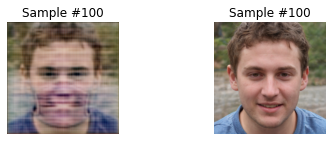

[Epoch 5/10] [Batch 101/180] [D loss: 0.470082] [G loss: 1.108947]
[Epoch 5/10] [Batch 102/180] [D loss: 0.439143] [G loss: 1.263729]
[Epoch 5/10] [Batch 103/180] [D loss: 0.391029] [G loss: 1.057540]
[Epoch 5/10] [Batch 104/180] [D loss: 0.346702] [G loss: 1.359609]
[Epoch 5/10] [Batch 105/180] [D loss: 0.374732] [G loss: 1.095898]
[Epoch 5/10] [Batch 106/180] [D loss: 0.350412] [G loss: 1.217029]
[Epoch 5/10] [Batch 107/180] [D loss: 0.435530] [G loss: 1.129715]
[Epoch 5/10] [Batch 108/180] [D loss: 0.307201] [G loss: 1.384899]
[Epoch 5/10] [Batch 109/180] [D loss: 0.309906] [G loss: 1.422345]
[Epoch 5/10] [Batch 110/180] [D loss: 0.328597] [G loss: 1.262809]
[Epoch 5/10] [Batch 111/180] [D loss: 0.266778] [G loss: 1.593127]
[Epoch 5/10] [Batch 112/180] [D loss: 0.228918] [G loss: 1.539293]
[Epoch 5/10] [Batch 113/180] [D loss: 0.257549] [G loss: 1.368379]
[Epoch 5/10] [Batch 114/180] [D loss: 0.474209] [G loss: 0.970385]
[Epoch 5/10] [Batch 115/180] [D loss: 0.648836] [G loss: 1.465

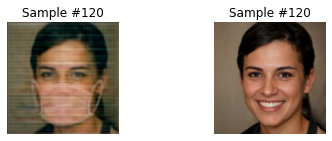

[Epoch 5/10] [Batch 121/180] [D loss: 0.713493] [G loss: 0.823642]
[Epoch 5/10] [Batch 122/180] [D loss: 0.671443] [G loss: 0.878433]
[Epoch 5/10] [Batch 123/180] [D loss: 0.666291] [G loss: 0.988970]
[Epoch 5/10] [Batch 124/180] [D loss: 0.574682] [G loss: 0.997178]
[Epoch 5/10] [Batch 125/180] [D loss: 0.629897] [G loss: 1.078032]
[Epoch 5/10] [Batch 126/180] [D loss: 0.608063] [G loss: 0.787598]
[Epoch 5/10] [Batch 127/180] [D loss: 0.491302] [G loss: 1.309783]
[Epoch 5/10] [Batch 128/180] [D loss: 0.464661] [G loss: 1.343918]
[Epoch 5/10] [Batch 129/180] [D loss: 0.427594] [G loss: 1.246336]
[Epoch 5/10] [Batch 130/180] [D loss: 0.493574] [G loss: 1.294393]
[Epoch 5/10] [Batch 131/180] [D loss: 0.680096] [G loss: 0.656915]
[Epoch 5/10] [Batch 132/180] [D loss: 0.689428] [G loss: 1.243152]
[Epoch 5/10] [Batch 133/180] [D loss: 0.487209] [G loss: 1.432453]
[Epoch 5/10] [Batch 134/180] [D loss: 0.379391] [G loss: 1.412068]
[Epoch 5/10] [Batch 135/180] [D loss: 0.410987] [G loss: 1.131

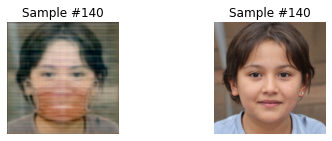

[Epoch 5/10] [Batch 141/180] [D loss: 0.321264] [G loss: 1.246149]
[Epoch 5/10] [Batch 142/180] [D loss: 0.311048] [G loss: 1.373575]
[Epoch 5/10] [Batch 143/180] [D loss: 0.277764] [G loss: 1.294567]
[Epoch 5/10] [Batch 144/180] [D loss: 0.313555] [G loss: 1.230886]
[Epoch 5/10] [Batch 145/180] [D loss: 0.345117] [G loss: 1.334934]
[Epoch 5/10] [Batch 146/180] [D loss: 0.296154] [G loss: 1.259437]
[Epoch 5/10] [Batch 147/180] [D loss: 0.375488] [G loss: 1.014081]
[Epoch 5/10] [Batch 148/180] [D loss: 0.503323] [G loss: 1.408112]
[Epoch 5/10] [Batch 149/180] [D loss: 0.288293] [G loss: 1.313799]
[Epoch 5/10] [Batch 150/180] [D loss: 0.366270] [G loss: 1.010013]
[Epoch 5/10] [Batch 151/180] [D loss: 0.506605] [G loss: 1.313056]
[Epoch 5/10] [Batch 152/180] [D loss: 0.377302] [G loss: 1.109162]
[Epoch 5/10] [Batch 153/180] [D loss: 0.592018] [G loss: 0.613370]
[Epoch 5/10] [Batch 154/180] [D loss: 0.716032] [G loss: 1.480317]
[Epoch 5/10] [Batch 155/180] [D loss: 0.682199] [G loss: 1.352

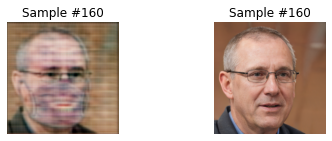

[Epoch 5/10] [Batch 161/180] [D loss: 0.556046] [G loss: 1.151041]
[Epoch 5/10] [Batch 162/180] [D loss: 0.437973] [G loss: 1.303833]
[Epoch 5/10] [Batch 163/180] [D loss: 0.473561] [G loss: 1.198768]
[Epoch 5/10] [Batch 164/180] [D loss: 0.461809] [G loss: 0.962218]
[Epoch 5/10] [Batch 165/180] [D loss: 0.516535] [G loss: 1.131328]
[Epoch 5/10] [Batch 166/180] [D loss: 0.477821] [G loss: 1.496136]
[Epoch 5/10] [Batch 167/180] [D loss: 0.290633] [G loss: 1.346985]
[Epoch 5/10] [Batch 168/180] [D loss: 0.280803] [G loss: 1.324622]
[Epoch 5/10] [Batch 169/180] [D loss: 0.310097] [G loss: 1.190227]
[Epoch 5/10] [Batch 170/180] [D loss: 0.350241] [G loss: 1.189475]
[Epoch 5/10] [Batch 171/180] [D loss: 0.399831] [G loss: 1.241182]
[Epoch 5/10] [Batch 172/180] [D loss: 0.410026] [G loss: 0.975326]
[Epoch 5/10] [Batch 173/180] [D loss: 0.450420] [G loss: 1.100566]
[Epoch 5/10] [Batch 174/180] [D loss: 0.400915] [G loss: 1.273922]
[Epoch 5/10] [Batch 175/180] [D loss: 0.520076] [G loss: 0.808

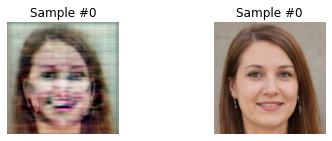

[Epoch 6/10] [Batch 1/180] [D loss: 0.341276] [G loss: 1.573018]
[Epoch 6/10] [Batch 2/180] [D loss: 0.234697] [G loss: 1.507134]
[Epoch 6/10] [Batch 3/180] [D loss: 0.230138] [G loss: 1.468662]
[Epoch 6/10] [Batch 4/180] [D loss: 0.305374] [G loss: 1.198641]
[Epoch 6/10] [Batch 5/180] [D loss: 0.288840] [G loss: 1.393121]
[Epoch 6/10] [Batch 6/180] [D loss: 0.380456] [G loss: 1.091157]
[Epoch 6/10] [Batch 7/180] [D loss: 0.510466] [G loss: 1.577023]
[Epoch 6/10] [Batch 8/180] [D loss: 0.328703] [G loss: 1.125486]
[Epoch 6/10] [Batch 9/180] [D loss: 0.269321] [G loss: 1.500736]
[Epoch 6/10] [Batch 10/180] [D loss: 0.312521] [G loss: 1.237319]
[Epoch 6/10] [Batch 11/180] [D loss: 0.557232] [G loss: 0.761184]
[Epoch 6/10] [Batch 12/180] [D loss: 0.634661] [G loss: 1.655558]
[Epoch 6/10] [Batch 13/180] [D loss: 0.214527] [G loss: 1.606563]
[Epoch 6/10] [Batch 14/180] [D loss: 0.278146] [G loss: 1.232863]
[Epoch 6/10] [Batch 15/180] [D loss: 0.281724] [G loss: 1.474232]
[Epoch 6/10] [Batch

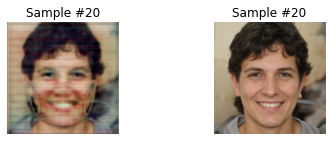

[Epoch 6/10] [Batch 21/180] [D loss: 0.848982] [G loss: 1.729347]
[Epoch 6/10] [Batch 22/180] [D loss: 0.762334] [G loss: 1.564063]
[Epoch 6/10] [Batch 23/180] [D loss: 0.748067] [G loss: 1.284522]
[Epoch 6/10] [Batch 24/180] [D loss: 0.737157] [G loss: 1.146191]
[Epoch 6/10] [Batch 25/180] [D loss: 0.649825] [G loss: 1.016054]
[Epoch 6/10] [Batch 26/180] [D loss: 0.591062] [G loss: 1.061072]
[Epoch 6/10] [Batch 27/180] [D loss: 0.474996] [G loss: 1.239013]
[Epoch 6/10] [Batch 28/180] [D loss: 0.477190] [G loss: 1.203266]
[Epoch 6/10] [Batch 29/180] [D loss: 0.473631] [G loss: 1.115370]
[Epoch 6/10] [Batch 30/180] [D loss: 0.401993] [G loss: 1.275880]
[Epoch 6/10] [Batch 31/180] [D loss: 0.432115] [G loss: 1.042171]
[Epoch 6/10] [Batch 32/180] [D loss: 0.370753] [G loss: 1.270836]
[Epoch 6/10] [Batch 33/180] [D loss: 0.370294] [G loss: 1.165372]
[Epoch 6/10] [Batch 34/180] [D loss: 0.432982] [G loss: 1.020127]
[Epoch 6/10] [Batch 35/180] [D loss: 0.427628] [G loss: 1.016857]
[Epoch 6/1

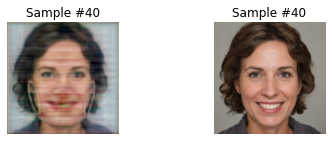

[Epoch 6/10] [Batch 41/180] [D loss: 0.517181] [G loss: 0.977834]
[Epoch 6/10] [Batch 42/180] [D loss: 0.546389] [G loss: 1.034436]
[Epoch 6/10] [Batch 43/180] [D loss: 0.583707] [G loss: 0.931151]
[Epoch 6/10] [Batch 44/180] [D loss: 0.513956] [G loss: 0.996652]
[Epoch 6/10] [Batch 45/180] [D loss: 0.502602] [G loss: 1.204737]
[Epoch 6/10] [Batch 46/180] [D loss: 0.492326] [G loss: 1.126704]
[Epoch 6/10] [Batch 47/180] [D loss: 0.429656] [G loss: 1.050000]
[Epoch 6/10] [Batch 48/180] [D loss: 0.458381] [G loss: 1.136533]
[Epoch 6/10] [Batch 49/180] [D loss: 0.440660] [G loss: 1.106739]
[Epoch 6/10] [Batch 50/180] [D loss: 0.470266] [G loss: 1.083306]
[Epoch 6/10] [Batch 51/180] [D loss: 0.401420] [G loss: 1.149739]
[Epoch 6/10] [Batch 52/180] [D loss: 0.374871] [G loss: 1.302932]
[Epoch 6/10] [Batch 53/180] [D loss: 0.385955] [G loss: 1.257234]
[Epoch 6/10] [Batch 54/180] [D loss: 0.373554] [G loss: 1.071704]
[Epoch 6/10] [Batch 55/180] [D loss: 0.344313] [G loss: 1.244963]
[Epoch 6/1

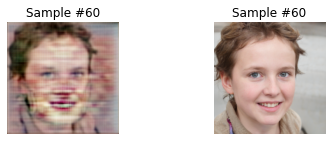

[Epoch 6/10] [Batch 61/180] [D loss: 0.228279] [G loss: 1.453593]
[Epoch 6/10] [Batch 62/180] [D loss: 0.228850] [G loss: 1.577016]
[Epoch 6/10] [Batch 63/180] [D loss: 0.277960] [G loss: 1.358459]
[Epoch 6/10] [Batch 64/180] [D loss: 0.276633] [G loss: 1.565005]
[Epoch 6/10] [Batch 65/180] [D loss: 0.235498] [G loss: 1.372859]
[Epoch 6/10] [Batch 66/180] [D loss: 0.235064] [G loss: 1.317965]
[Epoch 6/10] [Batch 67/180] [D loss: 0.582401] [G loss: 1.677348]
[Epoch 6/10] [Batch 68/180] [D loss: 0.539803] [G loss: 0.648239]
[Epoch 6/10] [Batch 69/180] [D loss: 0.681271] [G loss: 1.792539]
[Epoch 6/10] [Batch 70/180] [D loss: 0.663001] [G loss: 1.687871]
[Epoch 6/10] [Batch 71/180] [D loss: 0.496434] [G loss: 1.455439]
[Epoch 6/10] [Batch 72/180] [D loss: 0.386562] [G loss: 1.187863]
[Epoch 6/10] [Batch 73/180] [D loss: 0.539759] [G loss: 0.926578]
[Epoch 6/10] [Batch 74/180] [D loss: 0.557060] [G loss: 0.812855]
[Epoch 6/10] [Batch 75/180] [D loss: 0.439912] [G loss: 1.440238]
[Epoch 6/1

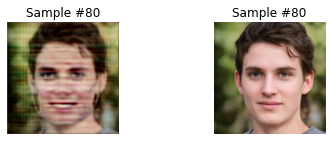

[Epoch 6/10] [Batch 81/180] [D loss: 0.393219] [G loss: 1.173656]
[Epoch 6/10] [Batch 82/180] [D loss: 0.368281] [G loss: 1.252979]
[Epoch 6/10] [Batch 83/180] [D loss: 0.403593] [G loss: 1.157873]
[Epoch 6/10] [Batch 84/180] [D loss: 0.401792] [G loss: 1.228058]
[Epoch 6/10] [Batch 85/180] [D loss: 0.355151] [G loss: 1.410771]
[Epoch 6/10] [Batch 86/180] [D loss: 0.340379] [G loss: 1.204766]
[Epoch 6/10] [Batch 87/180] [D loss: 0.302384] [G loss: 1.632625]
[Epoch 6/10] [Batch 88/180] [D loss: 0.312308] [G loss: 1.387861]
[Epoch 6/10] [Batch 89/180] [D loss: 0.206651] [G loss: 1.693101]
[Epoch 6/10] [Batch 90/180] [D loss: 0.223380] [G loss: 1.697576]
[Epoch 6/10] [Batch 91/180] [D loss: 0.172754] [G loss: 1.697770]
[Epoch 6/10] [Batch 92/180] [D loss: 0.238999] [G loss: 1.439201]
[Epoch 6/10] [Batch 93/180] [D loss: 0.433077] [G loss: 1.249215]
[Epoch 6/10] [Batch 94/180] [D loss: 0.428503] [G loss: 1.824873]
[Epoch 6/10] [Batch 95/180] [D loss: 0.222539] [G loss: 1.537572]
[Epoch 6/1

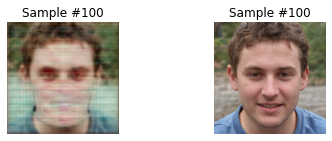

[Epoch 6/10] [Batch 101/180] [D loss: 0.192072] [G loss: 1.659451]
[Epoch 6/10] [Batch 102/180] [D loss: 0.185045] [G loss: 1.832823]
[Epoch 6/10] [Batch 103/180] [D loss: 0.179950] [G loss: 1.628061]
[Epoch 6/10] [Batch 104/180] [D loss: 0.202504] [G loss: 1.759770]
[Epoch 6/10] [Batch 105/180] [D loss: 0.219027] [G loss: 1.435459]
[Epoch 6/10] [Batch 106/180] [D loss: 0.294999] [G loss: 1.766606]
[Epoch 6/10] [Batch 107/180] [D loss: 0.543721] [G loss: 0.698550]
[Epoch 6/10] [Batch 108/180] [D loss: 0.506628] [G loss: 1.705476]
[Epoch 6/10] [Batch 109/180] [D loss: 0.229248] [G loss: 1.773642]
[Epoch 6/10] [Batch 110/180] [D loss: 0.233499] [G loss: 1.434086]
[Epoch 6/10] [Batch 111/180] [D loss: 0.247035] [G loss: 1.361186]
[Epoch 6/10] [Batch 112/180] [D loss: 0.246631] [G loss: 1.468451]
[Epoch 6/10] [Batch 113/180] [D loss: 0.358628] [G loss: 1.696788]
[Epoch 6/10] [Batch 114/180] [D loss: 0.616345] [G loss: 0.560334]
[Epoch 6/10] [Batch 115/180] [D loss: 0.762166] [G loss: 1.855

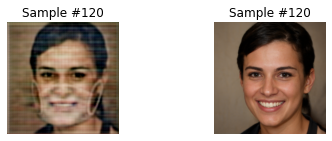

[Epoch 6/10] [Batch 121/180] [D loss: 0.581587] [G loss: 1.173852]
[Epoch 6/10] [Batch 122/180] [D loss: 0.422043] [G loss: 1.270667]
[Epoch 6/10] [Batch 123/180] [D loss: 0.344822] [G loss: 1.261632]
[Epoch 6/10] [Batch 124/180] [D loss: 0.335735] [G loss: 1.213337]
[Epoch 6/10] [Batch 125/180] [D loss: 0.322856] [G loss: 1.263030]
[Epoch 6/10] [Batch 126/180] [D loss: 0.288227] [G loss: 1.397046]
[Epoch 6/10] [Batch 127/180] [D loss: 0.387470] [G loss: 0.929483]
[Epoch 6/10] [Batch 128/180] [D loss: 0.676386] [G loss: 1.814398]
[Epoch 6/10] [Batch 129/180] [D loss: 0.485411] [G loss: 1.664459]
[Epoch 6/10] [Batch 130/180] [D loss: 0.350980] [G loss: 1.195297]
[Epoch 6/10] [Batch 131/180] [D loss: 0.254946] [G loss: 1.240060]
[Epoch 6/10] [Batch 132/180] [D loss: 0.316876] [G loss: 1.384002]
[Epoch 6/10] [Batch 133/180] [D loss: 0.247916] [G loss: 1.456146]
[Epoch 6/10] [Batch 134/180] [D loss: 0.311561] [G loss: 1.392290]
[Epoch 6/10] [Batch 135/180] [D loss: 0.329161] [G loss: 1.153

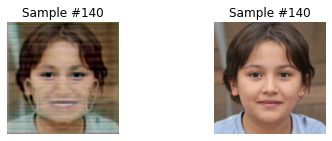

[Epoch 6/10] [Batch 141/180] [D loss: 0.478356] [G loss: 0.814604]
[Epoch 6/10] [Batch 142/180] [D loss: 0.586556] [G loss: 1.746607]
[Epoch 6/10] [Batch 143/180] [D loss: 0.490202] [G loss: 1.398679]
[Epoch 6/10] [Batch 144/180] [D loss: 0.590039] [G loss: 0.918226]
[Epoch 6/10] [Batch 145/180] [D loss: 0.527512] [G loss: 0.750038]
[Epoch 6/10] [Batch 146/180] [D loss: 0.386164] [G loss: 1.148278]
[Epoch 6/10] [Batch 147/180] [D loss: 0.287520] [G loss: 1.326867]
[Epoch 6/10] [Batch 148/180] [D loss: 0.255498] [G loss: 1.354844]
[Epoch 6/10] [Batch 149/180] [D loss: 0.220557] [G loss: 1.541432]
[Epoch 6/10] [Batch 150/180] [D loss: 0.244740] [G loss: 1.541531]
[Epoch 6/10] [Batch 151/180] [D loss: 0.534983] [G loss: 0.774302]
[Epoch 6/10] [Batch 152/180] [D loss: 0.911470] [G loss: 1.967498]
[Epoch 6/10] [Batch 153/180] [D loss: 0.823867] [G loss: 1.961966]
[Epoch 6/10] [Batch 154/180] [D loss: 0.734860] [G loss: 1.808986]
[Epoch 6/10] [Batch 155/180] [D loss: 0.541357] [G loss: 1.335

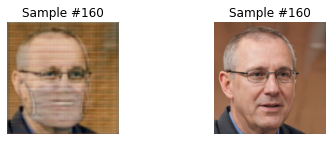

[Epoch 6/10] [Batch 161/180] [D loss: 0.243546] [G loss: 1.552891]
[Epoch 6/10] [Batch 162/180] [D loss: 0.313788] [G loss: 1.289438]
[Epoch 6/10] [Batch 163/180] [D loss: 0.351659] [G loss: 1.507883]
[Epoch 6/10] [Batch 164/180] [D loss: 0.267725] [G loss: 1.270622]
[Epoch 6/10] [Batch 165/180] [D loss: 0.292181] [G loss: 1.685418]
[Epoch 6/10] [Batch 166/180] [D loss: 0.253270] [G loss: 1.466593]
[Epoch 6/10] [Batch 167/180] [D loss: 0.260431] [G loss: 1.445453]
[Epoch 6/10] [Batch 168/180] [D loss: 0.323277] [G loss: 1.366256]
[Epoch 6/10] [Batch 169/180] [D loss: 0.505027] [G loss: 1.401015]
[Epoch 6/10] [Batch 170/180] [D loss: 0.863946] [G loss: 0.411091]
[Epoch 6/10] [Batch 171/180] [D loss: 0.974415] [G loss: 1.925655]
[Epoch 6/10] [Batch 172/180] [D loss: 0.960600] [G loss: 1.864582]
[Epoch 6/10] [Batch 173/180] [D loss: 0.877907] [G loss: 1.666922]
[Epoch 6/10] [Batch 174/180] [D loss: 0.794379] [G loss: 1.420564]
[Epoch 6/10] [Batch 175/180] [D loss: 0.751883] [G loss: 0.984

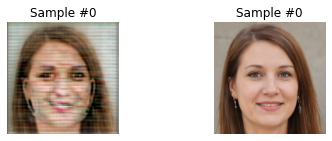

[Epoch 7/10] [Batch 1/180] [D loss: 0.637443] [G loss: 0.913875]
[Epoch 7/10] [Batch 2/180] [D loss: 0.641156] [G loss: 1.081037]
[Epoch 7/10] [Batch 3/180] [D loss: 0.541313] [G loss: 1.175019]
[Epoch 7/10] [Batch 4/180] [D loss: 0.531595] [G loss: 1.106222]
[Epoch 7/10] [Batch 5/180] [D loss: 0.467413] [G loss: 1.157814]
[Epoch 7/10] [Batch 6/180] [D loss: 0.478901] [G loss: 1.145774]
[Epoch 7/10] [Batch 7/180] [D loss: 0.452527] [G loss: 1.208061]
[Epoch 7/10] [Batch 8/180] [D loss: 0.544014] [G loss: 1.228318]
[Epoch 7/10] [Batch 9/180] [D loss: 0.580189] [G loss: 0.877343]
[Epoch 7/10] [Batch 10/180] [D loss: 0.457480] [G loss: 1.228467]
[Epoch 7/10] [Batch 11/180] [D loss: 0.404400] [G loss: 1.267782]
[Epoch 7/10] [Batch 12/180] [D loss: 0.381010] [G loss: 1.220631]
[Epoch 7/10] [Batch 13/180] [D loss: 0.341702] [G loss: 1.118605]
[Epoch 7/10] [Batch 14/180] [D loss: 0.302428] [G loss: 1.321937]
[Epoch 7/10] [Batch 15/180] [D loss: 0.251864] [G loss: 1.311130]
[Epoch 7/10] [Batch

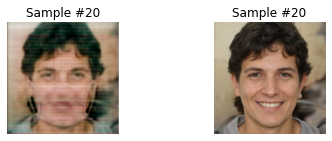

[Epoch 7/10] [Batch 21/180] [D loss: 0.270694] [G loss: 1.220682]
[Epoch 7/10] [Batch 22/180] [D loss: 0.357853] [G loss: 1.630062]
[Epoch 7/10] [Batch 23/180] [D loss: 1.165502] [G loss: 0.246738]
[Epoch 7/10] [Batch 24/180] [D loss: 0.903346] [G loss: 1.862597]
[Epoch 7/10] [Batch 25/180] [D loss: 0.818074] [G loss: 1.821614]
[Epoch 7/10] [Batch 26/180] [D loss: 0.715221] [G loss: 1.517574]
[Epoch 7/10] [Batch 27/180] [D loss: 0.640262] [G loss: 1.015023]
[Epoch 7/10] [Batch 28/180] [D loss: 0.581447] [G loss: 1.029203]
[Epoch 7/10] [Batch 29/180] [D loss: 0.449519] [G loss: 1.227095]
[Epoch 7/10] [Batch 30/180] [D loss: 0.396727] [G loss: 1.093157]
[Epoch 7/10] [Batch 31/180] [D loss: 0.315436] [G loss: 1.149837]
[Epoch 7/10] [Batch 32/180] [D loss: 0.285191] [G loss: 1.228063]
[Epoch 7/10] [Batch 33/180] [D loss: 0.223903] [G loss: 1.555736]
[Epoch 7/10] [Batch 34/180] [D loss: 0.237941] [G loss: 1.509052]
[Epoch 7/10] [Batch 35/180] [D loss: 0.277127] [G loss: 1.304705]
[Epoch 7/1

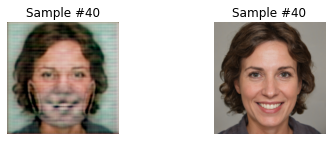

[Epoch 7/10] [Batch 41/180] [D loss: 0.744278] [G loss: 1.353277]
[Epoch 7/10] [Batch 42/180] [D loss: 0.698225] [G loss: 1.084563]
[Epoch 7/10] [Batch 43/180] [D loss: 0.697201] [G loss: 0.957033]
[Epoch 7/10] [Batch 44/180] [D loss: 0.680365] [G loss: 0.960008]
[Epoch 7/10] [Batch 45/180] [D loss: 0.641932] [G loss: 0.969862]
[Epoch 7/10] [Batch 46/180] [D loss: 0.571459] [G loss: 1.101811]
[Epoch 7/10] [Batch 47/180] [D loss: 0.538780] [G loss: 1.075786]
[Epoch 7/10] [Batch 48/180] [D loss: 0.521846] [G loss: 1.121831]
[Epoch 7/10] [Batch 49/180] [D loss: 0.481794] [G loss: 1.128910]
[Epoch 7/10] [Batch 50/180] [D loss: 0.480534] [G loss: 1.133083]
[Epoch 7/10] [Batch 51/180] [D loss: 0.437662] [G loss: 1.186096]
[Epoch 7/10] [Batch 52/180] [D loss: 0.394673] [G loss: 1.186285]
[Epoch 7/10] [Batch 53/180] [D loss: 0.370219] [G loss: 1.132333]
[Epoch 7/10] [Batch 54/180] [D loss: 0.472883] [G loss: 1.060496]
[Epoch 7/10] [Batch 55/180] [D loss: 0.410330] [G loss: 1.129791]
[Epoch 7/1

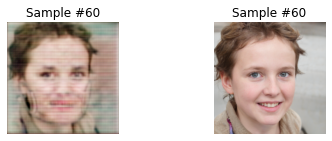

[Epoch 7/10] [Batch 61/180] [D loss: 0.280601] [G loss: 1.358627]
[Epoch 7/10] [Batch 62/180] [D loss: 0.279954] [G loss: 1.293268]
[Epoch 7/10] [Batch 63/180] [D loss: 0.327648] [G loss: 1.161430]
[Epoch 7/10] [Batch 64/180] [D loss: 0.213490] [G loss: 1.476663]
[Epoch 7/10] [Batch 65/180] [D loss: 0.209993] [G loss: 1.447240]
[Epoch 7/10] [Batch 66/180] [D loss: 0.205253] [G loss: 1.536994]
[Epoch 7/10] [Batch 67/180] [D loss: 0.249330] [G loss: 1.288786]
[Epoch 7/10] [Batch 68/180] [D loss: 0.281062] [G loss: 1.524007]
[Epoch 7/10] [Batch 69/180] [D loss: 0.399706] [G loss: 0.860693]
[Epoch 7/10] [Batch 70/180] [D loss: 0.492520] [G loss: 1.725392]
[Epoch 7/10] [Batch 71/180] [D loss: 0.216828] [G loss: 1.459996]
[Epoch 7/10] [Batch 72/180] [D loss: 0.215723] [G loss: 1.402665]
[Epoch 7/10] [Batch 73/180] [D loss: 0.195125] [G loss: 1.574031]
[Epoch 7/10] [Batch 74/180] [D loss: 0.192570] [G loss: 1.721766]
[Epoch 7/10] [Batch 75/180] [D loss: 0.168896] [G loss: 1.625169]
[Epoch 7/1

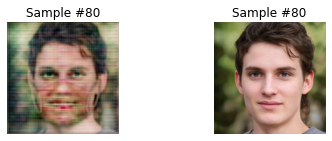

[Epoch 7/10] [Batch 81/180] [D loss: 0.680175] [G loss: 1.788452]
[Epoch 7/10] [Batch 82/180] [D loss: 0.495894] [G loss: 1.603876]
[Epoch 7/10] [Batch 83/180] [D loss: 0.497922] [G loss: 1.015888]
[Epoch 7/10] [Batch 84/180] [D loss: 0.370110] [G loss: 1.182535]
[Epoch 7/10] [Batch 85/180] [D loss: 0.320952] [G loss: 1.312486]
[Epoch 7/10] [Batch 86/180] [D loss: 0.270606] [G loss: 1.463542]
[Epoch 7/10] [Batch 87/180] [D loss: 0.273685] [G loss: 1.507934]
[Epoch 7/10] [Batch 88/180] [D loss: 0.249634] [G loss: 1.446109]
[Epoch 7/10] [Batch 89/180] [D loss: 0.255794] [G loss: 1.318089]
[Epoch 7/10] [Batch 90/180] [D loss: 0.254702] [G loss: 1.358603]
[Epoch 7/10] [Batch 91/180] [D loss: 0.267267] [G loss: 1.429762]
[Epoch 7/10] [Batch 92/180] [D loss: 0.295147] [G loss: 1.346482]
[Epoch 7/10] [Batch 93/180] [D loss: 0.373223] [G loss: 1.036960]
[Epoch 7/10] [Batch 94/180] [D loss: 0.440937] [G loss: 1.538148]
[Epoch 7/10] [Batch 95/180] [D loss: 0.321055] [G loss: 1.216653]
[Epoch 7/1

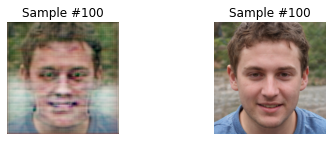

[Epoch 7/10] [Batch 101/180] [D loss: 0.445786] [G loss: 1.513495]
[Epoch 7/10] [Batch 102/180] [D loss: 0.307434] [G loss: 1.112884]
[Epoch 7/10] [Batch 103/180] [D loss: 0.251493] [G loss: 1.587210]
[Epoch 7/10] [Batch 104/180] [D loss: 0.284833] [G loss: 1.345960]
[Epoch 7/10] [Batch 105/180] [D loss: 0.440557] [G loss: 0.861117]
[Epoch 7/10] [Batch 106/180] [D loss: 0.782465] [G loss: 1.871083]
[Epoch 7/10] [Batch 107/180] [D loss: 0.755604] [G loss: 1.856016]
[Epoch 7/10] [Batch 108/180] [D loss: 0.618979] [G loss: 1.734795]
[Epoch 7/10] [Batch 109/180] [D loss: 0.484244] [G loss: 1.562087]
[Epoch 7/10] [Batch 110/180] [D loss: 0.390019] [G loss: 1.227670]
[Epoch 7/10] [Batch 111/180] [D loss: 0.327220] [G loss: 1.246988]
[Epoch 7/10] [Batch 112/180] [D loss: 0.282626] [G loss: 1.284720]
[Epoch 7/10] [Batch 113/180] [D loss: 0.379780] [G loss: 1.106531]
[Epoch 7/10] [Batch 114/180] [D loss: 0.473878] [G loss: 0.887157]
[Epoch 7/10] [Batch 115/180] [D loss: 0.468990] [G loss: 1.318

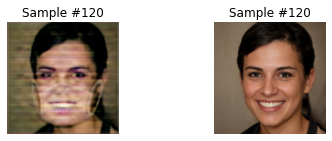

[Epoch 7/10] [Batch 121/180] [D loss: 0.580182] [G loss: 1.604311]
[Epoch 7/10] [Batch 122/180] [D loss: 0.483078] [G loss: 1.416663]
[Epoch 7/10] [Batch 123/180] [D loss: 0.416371] [G loss: 1.172080]
[Epoch 7/10] [Batch 124/180] [D loss: 0.423008] [G loss: 1.271914]
[Epoch 7/10] [Batch 125/180] [D loss: 0.284126] [G loss: 1.328902]
[Epoch 7/10] [Batch 126/180] [D loss: 0.239067] [G loss: 1.399014]
[Epoch 7/10] [Batch 127/180] [D loss: 0.258827] [G loss: 1.218089]
[Epoch 7/10] [Batch 128/180] [D loss: 0.388304] [G loss: 1.387752]
[Epoch 7/10] [Batch 129/180] [D loss: 0.315118] [G loss: 1.079891]
[Epoch 7/10] [Batch 130/180] [D loss: 0.227809] [G loss: 1.614440]
[Epoch 7/10] [Batch 131/180] [D loss: 0.186210] [G loss: 1.527730]
[Epoch 7/10] [Batch 132/180] [D loss: 0.207832] [G loss: 1.409397]
[Epoch 7/10] [Batch 133/180] [D loss: 0.233360] [G loss: 1.402478]
[Epoch 7/10] [Batch 134/180] [D loss: 0.353786] [G loss: 1.557653]
[Epoch 7/10] [Batch 135/180] [D loss: 0.887443] [G loss: 0.318

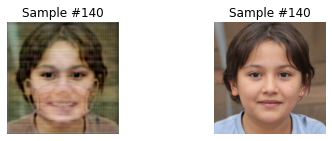

[Epoch 7/10] [Batch 141/180] [D loss: 0.370138] [G loss: 1.406607]
[Epoch 7/10] [Batch 142/180] [D loss: 0.373563] [G loss: 1.158077]
[Epoch 7/10] [Batch 143/180] [D loss: 0.420572] [G loss: 1.176168]
[Epoch 7/10] [Batch 144/180] [D loss: 0.404094] [G loss: 1.231267]
[Epoch 7/10] [Batch 145/180] [D loss: 0.351077] [G loss: 1.376026]
[Epoch 7/10] [Batch 146/180] [D loss: 0.271933] [G loss: 1.388177]
[Epoch 7/10] [Batch 147/180] [D loss: 0.241843] [G loss: 1.533598]
[Epoch 7/10] [Batch 148/180] [D loss: 0.279895] [G loss: 1.299463]
[Epoch 7/10] [Batch 149/180] [D loss: 0.252490] [G loss: 1.368617]
[Epoch 7/10] [Batch 150/180] [D loss: 0.306885] [G loss: 1.366055]
[Epoch 7/10] [Batch 151/180] [D loss: 0.330506] [G loss: 1.244408]
[Epoch 7/10] [Batch 152/180] [D loss: 0.347856] [G loss: 1.528164]
[Epoch 7/10] [Batch 153/180] [D loss: 0.792893] [G loss: 0.553258]
[Epoch 7/10] [Batch 154/180] [D loss: 0.713243] [G loss: 1.964652]
[Epoch 7/10] [Batch 155/180] [D loss: 0.603739] [G loss: 1.846

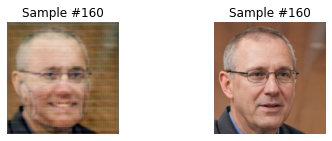

[Epoch 7/10] [Batch 161/180] [D loss: 0.259153] [G loss: 1.448265]
[Epoch 7/10] [Batch 162/180] [D loss: 0.411800] [G loss: 1.433659]
[Epoch 7/10] [Batch 163/180] [D loss: 0.506149] [G loss: 0.839252]
[Epoch 7/10] [Batch 164/180] [D loss: 0.440822] [G loss: 1.433197]
[Epoch 7/10] [Batch 165/180] [D loss: 0.378001] [G loss: 1.397400]
[Epoch 7/10] [Batch 166/180] [D loss: 0.242593] [G loss: 1.359015]
[Epoch 7/10] [Batch 167/180] [D loss: 0.196214] [G loss: 1.545278]
[Epoch 7/10] [Batch 168/180] [D loss: 0.164939] [G loss: 1.666835]
[Epoch 7/10] [Batch 169/180] [D loss: 0.145978] [G loss: 1.723313]
[Epoch 7/10] [Batch 170/180] [D loss: 0.168151] [G loss: 1.837515]
[Epoch 7/10] [Batch 171/180] [D loss: 0.146100] [G loss: 1.794408]
[Epoch 7/10] [Batch 172/180] [D loss: 0.162780] [G loss: 1.845618]
[Epoch 7/10] [Batch 173/180] [D loss: 0.140898] [G loss: 1.873737]
[Epoch 7/10] [Batch 174/180] [D loss: 0.154946] [G loss: 1.668231]
[Epoch 7/10] [Batch 175/180] [D loss: 0.164673] [G loss: 1.698

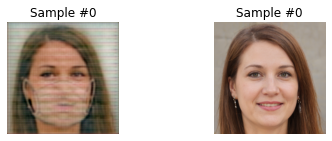

[Epoch 8/10] [Batch 1/180] [D loss: 0.160757] [G loss: 1.836896]
[Epoch 8/10] [Batch 2/180] [D loss: 0.148584] [G loss: 1.783326]
[Epoch 8/10] [Batch 3/180] [D loss: 0.185806] [G loss: 1.553233]
[Epoch 8/10] [Batch 4/180] [D loss: 0.179403] [G loss: 1.712793]
[Epoch 8/10] [Batch 5/180] [D loss: 0.171269] [G loss: 1.841468]
[Epoch 8/10] [Batch 6/180] [D loss: 0.206307] [G loss: 1.711807]
[Epoch 8/10] [Batch 7/180] [D loss: 0.198490] [G loss: 1.488619]
[Epoch 8/10] [Batch 8/180] [D loss: 0.237091] [G loss: 1.696598]
[Epoch 8/10] [Batch 9/180] [D loss: 0.200258] [G loss: 1.781025]
[Epoch 8/10] [Batch 10/180] [D loss: 0.165959] [G loss: 1.705449]
[Epoch 8/10] [Batch 11/180] [D loss: 0.169764] [G loss: 1.638689]
[Epoch 8/10] [Batch 12/180] [D loss: 0.197172] [G loss: 1.668143]
[Epoch 8/10] [Batch 13/180] [D loss: 0.216709] [G loss: 1.862625]
[Epoch 8/10] [Batch 14/180] [D loss: 0.472020] [G loss: 0.765372]
[Epoch 8/10] [Batch 15/180] [D loss: 0.916517] [G loss: 2.194059]
[Epoch 8/10] [Batch

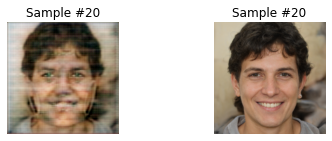

[Epoch 8/10] [Batch 21/180] [D loss: 0.595020] [G loss: 0.777013]
[Epoch 8/10] [Batch 22/180] [D loss: 0.445224] [G loss: 1.002309]
[Epoch 8/10] [Batch 23/180] [D loss: 0.400817] [G loss: 1.225724]
[Epoch 8/10] [Batch 24/180] [D loss: 0.306286] [G loss: 1.372007]
[Epoch 8/10] [Batch 25/180] [D loss: 0.241776] [G loss: 1.497770]
[Epoch 8/10] [Batch 26/180] [D loss: 0.238559] [G loss: 1.445625]
[Epoch 8/10] [Batch 27/180] [D loss: 0.233801] [G loss: 1.500364]
[Epoch 8/10] [Batch 28/180] [D loss: 0.406256] [G loss: 0.997471]
[Epoch 8/10] [Batch 29/180] [D loss: 0.582716] [G loss: 1.803410]
[Epoch 8/10] [Batch 30/180] [D loss: 0.650049] [G loss: 1.741797]
[Epoch 8/10] [Batch 31/180] [D loss: 0.420404] [G loss: 1.415085]
[Epoch 8/10] [Batch 32/180] [D loss: 0.399129] [G loss: 1.045341]
[Epoch 8/10] [Batch 33/180] [D loss: 0.283343] [G loss: 1.464262]
[Epoch 8/10] [Batch 34/180] [D loss: 0.235203] [G loss: 1.490109]
[Epoch 8/10] [Batch 35/180] [D loss: 0.239944] [G loss: 1.485907]
[Epoch 8/1

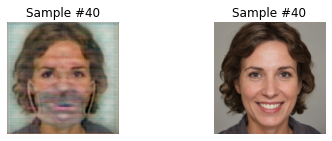

[Epoch 8/10] [Batch 41/180] [D loss: 0.292015] [G loss: 1.342642]
[Epoch 8/10] [Batch 42/180] [D loss: 0.178391] [G loss: 1.727109]
[Epoch 8/10] [Batch 43/180] [D loss: 0.219840] [G loss: 1.792324]
[Epoch 8/10] [Batch 44/180] [D loss: 0.277298] [G loss: 1.204444]
[Epoch 8/10] [Batch 45/180] [D loss: 0.473833] [G loss: 1.775002]
[Epoch 8/10] [Batch 46/180] [D loss: 0.490025] [G loss: 0.794427]
[Epoch 8/10] [Batch 47/180] [D loss: 0.670261] [G loss: 2.020958]
[Epoch 8/10] [Batch 48/180] [D loss: 0.175849] [G loss: 1.882913]
[Epoch 8/10] [Batch 49/180] [D loss: 0.178012] [G loss: 1.642507]
[Epoch 8/10] [Batch 50/180] [D loss: 0.343069] [G loss: 1.156294]
[Epoch 8/10] [Batch 51/180] [D loss: 0.500114] [G loss: 2.017150]
[Epoch 8/10] [Batch 52/180] [D loss: 0.196312] [G loss: 1.947455]
[Epoch 8/10] [Batch 53/180] [D loss: 0.217813] [G loss: 1.454122]
[Epoch 8/10] [Batch 54/180] [D loss: 0.204551] [G loss: 1.507442]
[Epoch 8/10] [Batch 55/180] [D loss: 0.325451] [G loss: 2.007792]
[Epoch 8/1

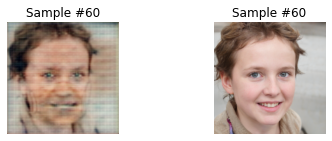

[Epoch 8/10] [Batch 61/180] [D loss: 1.359664] [G loss: 0.222312]
[Epoch 8/10] [Batch 62/180] [D loss: 0.817320] [G loss: 2.172400]
[Epoch 8/10] [Batch 63/180] [D loss: 0.468631] [G loss: 2.103300]
[Epoch 8/10] [Batch 64/180] [D loss: 0.148467] [G loss: 1.908998]
[Epoch 8/10] [Batch 65/180] [D loss: 0.169841] [G loss: 1.719947]
[Epoch 8/10] [Batch 66/180] [D loss: 0.210172] [G loss: 1.506859]
[Epoch 8/10] [Batch 67/180] [D loss: 0.296331] [G loss: 1.090847]
[Epoch 8/10] [Batch 68/180] [D loss: 0.208264] [G loss: 2.036705]
[Epoch 8/10] [Batch 69/180] [D loss: 0.269605] [G loss: 2.066527]
[Epoch 8/10] [Batch 70/180] [D loss: 0.161347] [G loss: 1.897622]
[Epoch 8/10] [Batch 71/180] [D loss: 0.410752] [G loss: 0.811094]
[Epoch 8/10] [Batch 72/180] [D loss: 0.536893] [G loss: 2.153284]
[Epoch 8/10] [Batch 73/180] [D loss: 0.208443] [G loss: 2.066570]
[Epoch 8/10] [Batch 74/180] [D loss: 0.135371] [G loss: 1.954549]
[Epoch 8/10] [Batch 75/180] [D loss: 0.147656] [G loss: 1.771128]
[Epoch 8/1

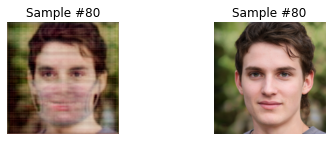

[Epoch 8/10] [Batch 81/180] [D loss: 0.613339] [G loss: 0.579038]
[Epoch 8/10] [Batch 82/180] [D loss: 0.955776] [G loss: 2.087000]
[Epoch 8/10] [Batch 83/180] [D loss: 0.828920] [G loss: 2.001761]
[Epoch 8/10] [Batch 84/180] [D loss: 0.576053] [G loss: 1.740260]
[Epoch 8/10] [Batch 85/180] [D loss: 0.426166] [G loss: 1.342751]
[Epoch 8/10] [Batch 86/180] [D loss: 0.469584] [G loss: 1.382189]
[Epoch 8/10] [Batch 87/180] [D loss: 0.361733] [G loss: 1.321401]
[Epoch 8/10] [Batch 88/180] [D loss: 0.371698] [G loss: 1.208751]
[Epoch 8/10] [Batch 89/180] [D loss: 0.418107] [G loss: 0.896574]
[Epoch 8/10] [Batch 90/180] [D loss: 0.488636] [G loss: 1.804400]
[Epoch 8/10] [Batch 91/180] [D loss: 0.265369] [G loss: 1.780993]
[Epoch 8/10] [Batch 92/180] [D loss: 0.228266] [G loss: 1.550320]
[Epoch 8/10] [Batch 93/180] [D loss: 0.257984] [G loss: 1.346164]
[Epoch 8/10] [Batch 94/180] [D loss: 0.265947] [G loss: 1.371834]
[Epoch 8/10] [Batch 95/180] [D loss: 0.242411] [G loss: 1.951158]
[Epoch 8/1

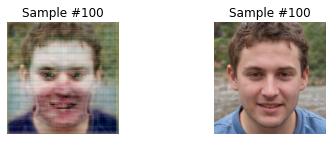

[Epoch 8/10] [Batch 101/180] [D loss: 0.920184] [G loss: 2.165797]
[Epoch 8/10] [Batch 102/180] [D loss: 0.948590] [G loss: 2.086324]
[Epoch 8/10] [Batch 103/180] [D loss: 0.798306] [G loss: 1.874210]
[Epoch 8/10] [Batch 104/180] [D loss: 0.637294] [G loss: 1.566339]
[Epoch 8/10] [Batch 105/180] [D loss: 0.628806] [G loss: 0.913493]
[Epoch 8/10] [Batch 106/180] [D loss: 0.477252] [G loss: 1.181243]
[Epoch 8/10] [Batch 107/180] [D loss: 0.474098] [G loss: 1.336050]
[Epoch 8/10] [Batch 108/180] [D loss: 0.402380] [G loss: 1.246032]
[Epoch 8/10] [Batch 109/180] [D loss: 0.355867] [G loss: 1.413016]
[Epoch 8/10] [Batch 110/180] [D loss: 0.262626] [G loss: 1.394015]
[Epoch 8/10] [Batch 111/180] [D loss: 0.259708] [G loss: 1.469846]
[Epoch 8/10] [Batch 112/180] [D loss: 0.293266] [G loss: 1.310055]
[Epoch 8/10] [Batch 113/180] [D loss: 0.218163] [G loss: 1.487627]
[Epoch 8/10] [Batch 114/180] [D loss: 0.219390] [G loss: 1.504767]
[Epoch 8/10] [Batch 115/180] [D loss: 0.215461] [G loss: 1.527

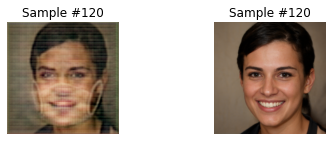

[Epoch 8/10] [Batch 121/180] [D loss: 0.433126] [G loss: 1.531003]
[Epoch 8/10] [Batch 122/180] [D loss: 0.279842] [G loss: 1.294760]
[Epoch 8/10] [Batch 123/180] [D loss: 0.293903] [G loss: 1.287091]
[Epoch 8/10] [Batch 124/180] [D loss: 0.214015] [G loss: 1.841313]
[Epoch 8/10] [Batch 125/180] [D loss: 0.322205] [G loss: 1.193213]
[Epoch 8/10] [Batch 126/180] [D loss: 0.507907] [G loss: 1.896621]
[Epoch 8/10] [Batch 127/180] [D loss: 0.215366] [G loss: 1.563868]
[Epoch 8/10] [Batch 128/180] [D loss: 0.264712] [G loss: 1.592307]
[Epoch 8/10] [Batch 129/180] [D loss: 0.325696] [G loss: 1.020447]
[Epoch 8/10] [Batch 130/180] [D loss: 0.859853] [G loss: 2.045484]
[Epoch 8/10] [Batch 131/180] [D loss: 0.738972] [G loss: 1.922925]
[Epoch 8/10] [Batch 132/180] [D loss: 0.580029] [G loss: 1.420823]
[Epoch 8/10] [Batch 133/180] [D loss: 0.424630] [G loss: 1.284199]
[Epoch 8/10] [Batch 134/180] [D loss: 0.418880] [G loss: 1.293276]
[Epoch 8/10] [Batch 135/180] [D loss: 0.263074] [G loss: 1.476

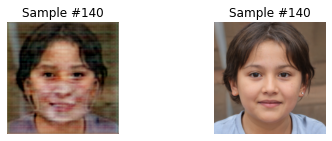

[Epoch 8/10] [Batch 141/180] [D loss: 0.217815] [G loss: 1.451836]
[Epoch 8/10] [Batch 142/180] [D loss: 0.221325] [G loss: 1.483028]
[Epoch 8/10] [Batch 143/180] [D loss: 0.234828] [G loss: 1.537467]
[Epoch 8/10] [Batch 144/180] [D loss: 0.193654] [G loss: 1.561398]
[Epoch 8/10] [Batch 145/180] [D loss: 0.167535] [G loss: 1.693498]
[Epoch 8/10] [Batch 146/180] [D loss: 0.177993] [G loss: 1.787141]
[Epoch 8/10] [Batch 147/180] [D loss: 0.178103] [G loss: 1.593619]
[Epoch 8/10] [Batch 148/180] [D loss: 0.177081] [G loss: 1.782075]
[Epoch 8/10] [Batch 149/180] [D loss: 0.307623] [G loss: 1.145904]
[Epoch 8/10] [Batch 150/180] [D loss: 0.706437] [G loss: 2.035857]
[Epoch 8/10] [Batch 151/180] [D loss: 0.617275] [G loss: 2.010391]
[Epoch 8/10] [Batch 152/180] [D loss: 0.419910] [G loss: 1.690315]
[Epoch 8/10] [Batch 153/180] [D loss: 0.321472] [G loss: 1.248003]
[Epoch 8/10] [Batch 154/180] [D loss: 0.237584] [G loss: 1.423902]
[Epoch 8/10] [Batch 155/180] [D loss: 0.199300] [G loss: 1.549

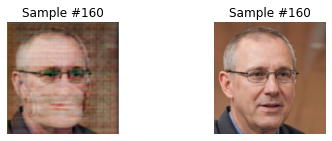

[Epoch 8/10] [Batch 161/180] [D loss: 0.148633] [G loss: 1.738965]
[Epoch 8/10] [Batch 162/180] [D loss: 0.156804] [G loss: 1.757291]
[Epoch 8/10] [Batch 163/180] [D loss: 0.193835] [G loss: 1.586644]
[Epoch 8/10] [Batch 164/180] [D loss: 0.177970] [G loss: 1.832129]
[Epoch 8/10] [Batch 165/180] [D loss: 0.162221] [G loss: 1.748418]
[Epoch 8/10] [Batch 166/180] [D loss: 0.222432] [G loss: 1.385358]
[Epoch 8/10] [Batch 167/180] [D loss: 0.200673] [G loss: 1.713144]
[Epoch 8/10] [Batch 168/180] [D loss: 0.197825] [G loss: 1.615225]
[Epoch 8/10] [Batch 169/180] [D loss: 0.162708] [G loss: 1.655928]
[Epoch 8/10] [Batch 170/180] [D loss: 0.125885] [G loss: 2.024940]
[Epoch 8/10] [Batch 171/180] [D loss: 0.139887] [G loss: 1.830625]
[Epoch 8/10] [Batch 172/180] [D loss: 0.213218] [G loss: 1.593348]
[Epoch 8/10] [Batch 173/180] [D loss: 0.233340] [G loss: 2.036400]
[Epoch 8/10] [Batch 174/180] [D loss: 0.946184] [G loss: 0.388492]
[Epoch 8/10] [Batch 175/180] [D loss: 1.112298] [G loss: 2.392

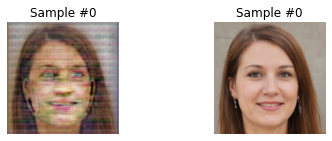

[Epoch 9/10] [Batch 1/180] [D loss: 0.663532] [G loss: 1.274507]
[Epoch 9/10] [Batch 2/180] [D loss: 0.663725] [G loss: 1.052673]
[Epoch 9/10] [Batch 3/180] [D loss: 0.624772] [G loss: 1.331090]
[Epoch 9/10] [Batch 4/180] [D loss: 0.795150] [G loss: 1.098408]
[Epoch 9/10] [Batch 5/180] [D loss: 0.763336] [G loss: 1.005355]
[Epoch 9/10] [Batch 6/180] [D loss: 0.763492] [G loss: 1.189284]
[Epoch 9/10] [Batch 7/180] [D loss: 0.590178] [G loss: 1.016763]
[Epoch 9/10] [Batch 8/180] [D loss: 0.678943] [G loss: 1.117957]
[Epoch 9/10] [Batch 9/180] [D loss: 0.877449] [G loss: 1.211469]
[Epoch 9/10] [Batch 10/180] [D loss: 0.499916] [G loss: 1.280118]
[Epoch 9/10] [Batch 11/180] [D loss: 0.565217] [G loss: 1.449772]
[Epoch 9/10] [Batch 12/180] [D loss: 0.364127] [G loss: 1.367148]
[Epoch 9/10] [Batch 13/180] [D loss: 0.455775] [G loss: 0.877132]
[Epoch 9/10] [Batch 14/180] [D loss: 0.397555] [G loss: 1.707966]
[Epoch 9/10] [Batch 15/180] [D loss: 0.289266] [G loss: 1.611817]
[Epoch 9/10] [Batch

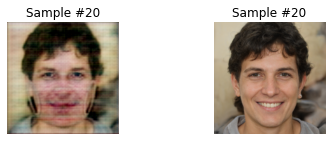

[Epoch 9/10] [Batch 21/180] [D loss: 0.688104] [G loss: 1.849233]
[Epoch 9/10] [Batch 22/180] [D loss: 0.618564] [G loss: 1.650560]
[Epoch 9/10] [Batch 23/180] [D loss: 0.472866] [G loss: 1.381188]
[Epoch 9/10] [Batch 24/180] [D loss: 0.431534] [G loss: 1.195131]
[Epoch 9/10] [Batch 25/180] [D loss: 0.417693] [G loss: 1.186286]
[Epoch 9/10] [Batch 26/180] [D loss: 0.427734] [G loss: 1.088422]
[Epoch 9/10] [Batch 27/180] [D loss: 0.330391] [G loss: 1.419551]
[Epoch 9/10] [Batch 28/180] [D loss: 0.306216] [G loss: 1.412523]
[Epoch 9/10] [Batch 29/180] [D loss: 0.301384] [G loss: 1.521833]
[Epoch 9/10] [Batch 30/180] [D loss: 0.235089] [G loss: 1.519739]
[Epoch 9/10] [Batch 31/180] [D loss: 0.309928] [G loss: 1.222203]
[Epoch 9/10] [Batch 32/180] [D loss: 0.316489] [G loss: 1.248070]
[Epoch 9/10] [Batch 33/180] [D loss: 0.315350] [G loss: 1.293579]
[Epoch 9/10] [Batch 34/180] [D loss: 0.470080] [G loss: 1.213385]
[Epoch 9/10] [Batch 35/180] [D loss: 0.373674] [G loss: 1.130866]
[Epoch 9/1

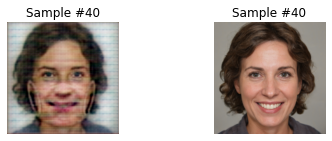

[Epoch 9/10] [Batch 41/180] [D loss: 0.312238] [G loss: 1.138903]
[Epoch 9/10] [Batch 42/180] [D loss: 0.380021] [G loss: 1.649467]
[Epoch 9/10] [Batch 43/180] [D loss: 0.622027] [G loss: 0.607230]
[Epoch 9/10] [Batch 44/180] [D loss: 0.816634] [G loss: 2.049626]
[Epoch 9/10] [Batch 45/180] [D loss: 0.844572] [G loss: 1.985290]
[Epoch 9/10] [Batch 46/180] [D loss: 0.738238] [G loss: 1.713147]
[Epoch 9/10] [Batch 47/180] [D loss: 0.674010] [G loss: 1.359035]
[Epoch 9/10] [Batch 48/180] [D loss: 0.631487] [G loss: 1.248507]
[Epoch 9/10] [Batch 49/180] [D loss: 0.646122] [G loss: 1.165496]
[Epoch 9/10] [Batch 50/180] [D loss: 0.493215] [G loss: 1.304946]
[Epoch 9/10] [Batch 51/180] [D loss: 0.505282] [G loss: 1.534147]
[Epoch 9/10] [Batch 52/180] [D loss: 0.441935] [G loss: 1.531922]
[Epoch 9/10] [Batch 53/180] [D loss: 0.364859] [G loss: 1.346568]
[Epoch 9/10] [Batch 54/180] [D loss: 0.337341] [G loss: 1.182194]
[Epoch 9/10] [Batch 55/180] [D loss: 0.413751] [G loss: 0.974784]
[Epoch 9/1

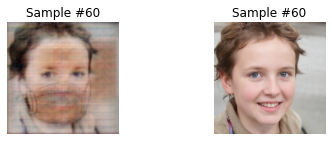

[Epoch 9/10] [Batch 61/180] [D loss: 0.262589] [G loss: 1.298149]
[Epoch 9/10] [Batch 62/180] [D loss: 0.257409] [G loss: 1.293528]
[Epoch 9/10] [Batch 63/180] [D loss: 0.424868] [G loss: 0.995587]
[Epoch 9/10] [Batch 64/180] [D loss: 0.343293] [G loss: 1.551510]
[Epoch 9/10] [Batch 65/180] [D loss: 0.367889] [G loss: 1.142746]
[Epoch 9/10] [Batch 66/180] [D loss: 0.338328] [G loss: 1.318621]
[Epoch 9/10] [Batch 67/180] [D loss: 0.380702] [G loss: 1.041075]
[Epoch 9/10] [Batch 68/180] [D loss: 0.490488] [G loss: 1.603969]
[Epoch 9/10] [Batch 69/180] [D loss: 0.397721] [G loss: 0.939875]
[Epoch 9/10] [Batch 70/180] [D loss: 0.365237] [G loss: 1.646796]
[Epoch 9/10] [Batch 71/180] [D loss: 0.233850] [G loss: 1.559499]
[Epoch 9/10] [Batch 72/180] [D loss: 0.278802] [G loss: 1.252553]
[Epoch 9/10] [Batch 73/180] [D loss: 0.186196] [G loss: 1.570772]
[Epoch 9/10] [Batch 74/180] [D loss: 0.180417] [G loss: 1.648818]
[Epoch 9/10] [Batch 75/180] [D loss: 0.163401] [G loss: 1.693531]
[Epoch 9/1

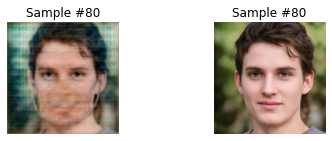

[Epoch 9/10] [Batch 81/180] [D loss: 0.433290] [G loss: 0.956800]
[Epoch 9/10] [Batch 82/180] [D loss: 0.905462] [G loss: 2.097890]
[Epoch 9/10] [Batch 83/180] [D loss: 0.846046] [G loss: 2.092856]
[Epoch 9/10] [Batch 84/180] [D loss: 0.556479] [G loss: 1.856774]
[Epoch 9/10] [Batch 85/180] [D loss: 0.415448] [G loss: 1.341227]
[Epoch 9/10] [Batch 86/180] [D loss: 0.434573] [G loss: 1.054776]
[Epoch 9/10] [Batch 87/180] [D loss: 0.398262] [G loss: 1.277860]
[Epoch 9/10] [Batch 88/180] [D loss: 0.331919] [G loss: 1.515998]
[Epoch 9/10] [Batch 89/180] [D loss: 0.277117] [G loss: 1.350317]
[Epoch 9/10] [Batch 90/180] [D loss: 0.268844] [G loss: 1.302083]
[Epoch 9/10] [Batch 91/180] [D loss: 0.323305] [G loss: 1.381818]
[Epoch 9/10] [Batch 92/180] [D loss: 0.295718] [G loss: 1.363616]
[Epoch 9/10] [Batch 93/180] [D loss: 0.240040] [G loss: 1.615539]
[Epoch 9/10] [Batch 94/180] [D loss: 0.275641] [G loss: 1.126623]
[Epoch 9/10] [Batch 95/180] [D loss: 0.310068] [G loss: 1.808381]
[Epoch 9/1

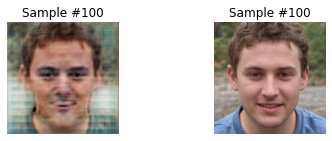

[Epoch 9/10] [Batch 101/180] [D loss: 1.019730] [G loss: 2.124663]
[Epoch 9/10] [Batch 102/180] [D loss: 1.007548] [G loss: 2.110357]
[Epoch 9/10] [Batch 103/180] [D loss: 0.888844] [G loss: 1.919862]
[Epoch 9/10] [Batch 104/180] [D loss: 0.832577] [G loss: 1.616698]
[Epoch 9/10] [Batch 105/180] [D loss: 0.909210] [G loss: 0.902947]
[Epoch 9/10] [Batch 106/180] [D loss: 0.642726] [G loss: 1.087696]
[Epoch 9/10] [Batch 107/180] [D loss: 0.640323] [G loss: 1.197138]
[Epoch 9/10] [Batch 108/180] [D loss: 0.576859] [G loss: 1.230840]
[Epoch 9/10] [Batch 109/180] [D loss: 0.572972] [G loss: 1.224322]
[Epoch 9/10] [Batch 110/180] [D loss: 0.486240] [G loss: 1.254359]
[Epoch 9/10] [Batch 111/180] [D loss: 0.493733] [G loss: 1.272368]
[Epoch 9/10] [Batch 112/180] [D loss: 0.548120] [G loss: 0.972171]
[Epoch 9/10] [Batch 113/180] [D loss: 0.544919] [G loss: 1.126628]
[Epoch 9/10] [Batch 114/180] [D loss: 0.520261] [G loss: 1.120725]
[Epoch 9/10] [Batch 115/180] [D loss: 0.559023] [G loss: 1.046

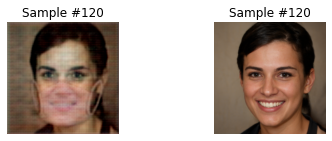

[Epoch 9/10] [Batch 121/180] [D loss: 0.462195] [G loss: 1.080296]
[Epoch 9/10] [Batch 122/180] [D loss: 0.430701] [G loss: 1.164377]
[Epoch 9/10] [Batch 123/180] [D loss: 0.456659] [G loss: 1.071263]
[Epoch 9/10] [Batch 124/180] [D loss: 0.415667] [G loss: 1.154115]
[Epoch 9/10] [Batch 125/180] [D loss: 0.327114] [G loss: 1.478990]
[Epoch 9/10] [Batch 126/180] [D loss: 0.336849] [G loss: 1.335885]
[Epoch 9/10] [Batch 127/180] [D loss: 0.338523] [G loss: 1.296750]
[Epoch 9/10] [Batch 128/180] [D loss: 0.382473] [G loss: 1.158496]
[Epoch 9/10] [Batch 129/180] [D loss: 0.395190] [G loss: 1.355301]
[Epoch 9/10] [Batch 130/180] [D loss: 0.406733] [G loss: 1.280092]
[Epoch 9/10] [Batch 131/180] [D loss: 0.383031] [G loss: 1.243625]
[Epoch 9/10] [Batch 132/180] [D loss: 0.406649] [G loss: 1.163897]
[Epoch 9/10] [Batch 133/180] [D loss: 0.412317] [G loss: 1.168574]
[Epoch 9/10] [Batch 134/180] [D loss: 0.624965] [G loss: 0.925181]
[Epoch 9/10] [Batch 135/180] [D loss: 0.468832] [G loss: 1.150

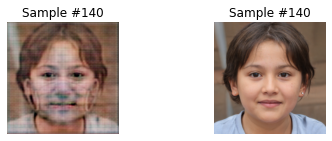

[Epoch 9/10] [Batch 141/180] [D loss: 0.294334] [G loss: 1.319741]
[Epoch 9/10] [Batch 142/180] [D loss: 0.224766] [G loss: 1.559708]
[Epoch 9/10] [Batch 143/180] [D loss: 0.241286] [G loss: 1.379243]
[Epoch 9/10] [Batch 144/180] [D loss: 0.229236] [G loss: 1.536068]
[Epoch 9/10] [Batch 145/180] [D loss: 0.238153] [G loss: 1.579477]
[Epoch 9/10] [Batch 146/180] [D loss: 0.426195] [G loss: 0.929351]
[Epoch 9/10] [Batch 147/180] [D loss: 0.733564] [G loss: 1.980781]
[Epoch 9/10] [Batch 148/180] [D loss: 0.620614] [G loss: 1.775702]
[Epoch 9/10] [Batch 149/180] [D loss: 0.388830] [G loss: 1.256970]
[Epoch 9/10] [Batch 150/180] [D loss: 0.250042] [G loss: 1.322303]
[Epoch 9/10] [Batch 151/180] [D loss: 0.235177] [G loss: 1.487294]
[Epoch 9/10] [Batch 152/180] [D loss: 0.258741] [G loss: 1.467565]
[Epoch 9/10] [Batch 153/180] [D loss: 0.288512] [G loss: 1.222600]
[Epoch 9/10] [Batch 154/180] [D loss: 0.277323] [G loss: 1.596962]
[Epoch 9/10] [Batch 155/180] [D loss: 0.191621] [G loss: 1.565

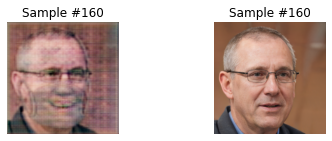

[Epoch 9/10] [Batch 161/180] [D loss: 0.296169] [G loss: 1.716576]
[Epoch 9/10] [Batch 162/180] [D loss: 0.335438] [G loss: 1.062056]
[Epoch 9/10] [Batch 163/180] [D loss: 0.555639] [G loss: 0.801907]
[Epoch 9/10] [Batch 164/180] [D loss: 0.600949] [G loss: 1.726843]
[Epoch 9/10] [Batch 165/180] [D loss: 0.406859] [G loss: 1.752970]
[Epoch 9/10] [Batch 166/180] [D loss: 0.704425] [G loss: 0.657690]
[Epoch 9/10] [Batch 167/180] [D loss: 0.492639] [G loss: 1.578221]
[Epoch 9/10] [Batch 168/180] [D loss: 0.590690] [G loss: 1.433821]
[Epoch 9/10] [Batch 169/180] [D loss: 0.588172] [G loss: 1.192739]
[Epoch 9/10] [Batch 170/180] [D loss: 0.521701] [G loss: 1.157669]
[Epoch 9/10] [Batch 171/180] [D loss: 0.472204] [G loss: 1.369230]
[Epoch 9/10] [Batch 172/180] [D loss: 0.381619] [G loss: 1.111042]
[Epoch 9/10] [Batch 173/180] [D loss: 0.357659] [G loss: 1.231906]
[Epoch 9/10] [Batch 174/180] [D loss: 0.394930] [G loss: 1.034046]
[Epoch 9/10] [Batch 175/180] [D loss: 0.391434] [G loss: 1.515

In [16]:
val_loss = []
train_loss = []
for epoch in range(args.EPOCHS):
    val_loss_=0
    train_loss_=0
    generator.train()
    discriminator.train()
    for i, (face_imgs, mask_imgs) in enumerate(train_dataloader):
        valid = Variable(Tensor(face_imgs.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(face_imgs.shape[0], 1).fill_(0.0), requires_grad=False).to(device)
        face_imgs = Variable(face_imgs.type(Tensor)).to(device)
        mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)

        optimizer_G.zero_grad()
        gen_imgs = generator(mask_imgs)
        fake_logits = discriminator(gen_imgs).view(face_imgs.shape[0], -1)
        g_loss = adversarial_loss(fake_logits, valid) + lambda_pixel*l1_loss(gen_imgs, face_imgs)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_logits = discriminator(face_imgs).view(face_imgs.shape[0], -1)
        fake_logits = discriminator(gen_imgs.detach()).view(face_imgs.shape[0], -1)
        real_loss = adversarial_loss(real_logits, valid)
        fake_loss = adversarial_loss(fake_logits, fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        train_loss_ += g_loss.item() + d_loss.item()
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, args.EPOCHS, i, len(train_dataloader), d_loss.item(), g_loss.item())
        )
        
        if i%20 == 0:
            ax = plt.subplot(2, 2, 1)
            plt.tight_layout()
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')
            sample_img = np.transpose(gen_imgs[0].cpu().detach().numpy(), (1,2,0))
            plt.imshow(sample_img)

            ax = plt.subplot(2, 2, 2)
            plt.tight_layout()
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')
            sample_img = np.transpose(face_imgs[0].cpu().detach().numpy(), (1,2,0))
            plt.imshow(sample_img)

            plt.show()
        
    train_loss_ /= len(train_dataloader)
    
    generator.eval()
    discriminator.eval()
    for i, (face_imgs, mask_imgs) in enumerate(test_dataloader):
        face_imgs = Variable(face_imgs.type(Tensor)).to(device)
        mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)

        gen_imgs = generator(mask_imgs)
        g_loss = adversarial_loss(discriminator(gen_imgs).view(face_imgs.shape[0], -1), valid) + lambda_pixel*l1_loss(gen_imgs, face_imgs)
        real_loss = adversarial_loss(discriminator(face_imgs).view(face_imgs.shape[0], -1), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).view(face_imgs.shape[0], -1), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        val_loss_ += g_loss.item() + d_loss.item()
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, args.EPOCHS, i, len(test_dataloader), d_loss.item(), g_loss.item())
        )
        
    val_loss_ /= len(test_dataloader)

    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    

torch.save(generator.state_dict(), "./saved_model/pix2pix_generator_lambda{}.pth".format(lambda_pixel))
torch.save(discriminator.state_dict(), "./saved_model/pix2pix_discriminator_lambda{}.pth".format(lambda_pixel))

In [17]:
import pandas as pd
loss_df = pd.DataFrame(data={'train_loss': train_loss, 'val_loss': val_loss})
loss_df.to_csv('./saved_model/pix2pix_loss_lambda{}.csv'.format(lambda_pixel), index=False)

In [ ]:
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

In [ ]:
val_loss = []
train_loss = []
for epoch in range(args.EPOCHS):
    val_loss_=0
    train_loss_=0
    generator.train()
    discriminator.train()
    for i, (face_imgs, mask_imgs) in enumerate(train_dataloader):
        valid = Variable(Tensor(face_imgs.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(face_imgs.shape[0], 1).fill_(0.0), requires_grad=False).to(device)
        face_imgs = Variable(face_imgs.type(Tensor)).to(device)
        mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)

        optimizer_G.zero_grad()
        gen_imgs = generator(mask_imgs)
        fake_logits = discriminator(gen_imgs).view(face_imgs.shape[0], -1)
        g_loss = adversarial_loss(fake_logits, valid) + lambda_pixel*l1_loss(gen_imgs, face_imgs)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_logits = discriminator(face_imgs).view(face_imgs.shape[0], -1)
        fake_logits = discriminator(gen_imgs.detach()).view(face_imgs.shape[0], -1)
        real_loss = adversarial_loss(real_logits, valid)
        fake_loss = adversarial_loss(fake_logits, fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        train_loss_ += g_loss.item() + d_loss.item()
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, args.EPOCHS, i, len(train_dataloader), d_loss.item(), g_loss.item())
        )
        
        if i%20 == 0:
            ax = plt.subplot(2, 2, 1)
            plt.tight_layout()
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')
            sample_img = np.transpose(gen_imgs[0].cpu().detach().numpy(), (1,2,0))
            plt.imshow(sample_img)

            ax = plt.subplot(2, 2, 2)
            plt.tight_layout()
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')
            sample_img = np.transpose(face_imgs[0].cpu().detach().numpy(), (1,2,0))
            plt.imshow(sample_img)

            plt.show()
        
    train_loss_ /= len(train_dataloader)
    
    generator.eval()
    discriminator.eval()
    for i, (face_imgs, mask_imgs) in enumerate(test_dataloader):
        face_imgs = Variable(face_imgs.type(Tensor)).to(device)
        mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)

        gen_imgs = generator(mask_imgs)
        g_loss = adversarial_loss(discriminator(gen_imgs).view(face_imgs.shape[0], -1), valid) + lambda_pixel*l1_loss(gen_imgs, face_imgs)
        real_loss = adversarial_loss(discriminator(face_imgs).view(face_imgs.shape[0], -1), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).view(face_imgs.shape[0], -1), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        val_loss_ += g_loss.item() + d_loss.item()
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, args.EPOCHS, i, len(test_dataloader), d_loss.item(), g_loss.item())
        )
        
    val_loss_ /= len(test_dataloader)

    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    

torch.save(generator.state_dict(), "./saved_model/pix2pix_generator_lambda{}.pth".format(lambda_pixel))
torch.save(discriminator.state_dict(), "./saved_model/pix2pix_discriminator_lambda{}.pth".format(lambda_pixel))

In [ ]:
generator.load_state_dict(torch.load('../input/dcgan-generator/pix2pix_generator_lambda1.pth'))

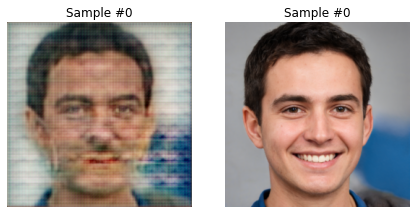

In [18]:
generator.eval()
sample = test_dataset[0]
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
mask_img = Variable(sample[1].type(Tensor)).to(device)
gen_img = generator(mask_img.unsqueeze(0))
sample_img = np.transpose(gen_img.cpu().detach().numpy().squeeze(0), (1,2,0))
plt.imshow(sample_img)

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
sample_img = np.transpose(sample[0].cpu().detach().numpy(), (1,2,0))
plt.imshow(sample_img)

plt.show()

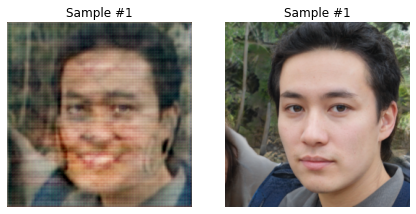

In [19]:
generator.eval()
sample = test_dataset[1]
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
mask_img = Variable(sample[1].type(Tensor)).to(device)
gen_img = generator(mask_img.unsqueeze(0))
sample_img = np.transpose(gen_img.cpu().detach().numpy().squeeze(0), (1,2,0))
plt.imshow(sample_img)

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
sample_img = np.transpose(sample[0].cpu().detach().numpy(), (1,2,0))
plt.imshow(sample_img)

plt.show()

In [ ]:
generator.eval()
l1_loss_value = 0
mse_loss_value = 0
for i, (face_imgs, mask_imgs) in enumerate(test_dataloader):
    face_imgs = Variable(face_imgs.type(Tensor)).to(device)
    mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)
    gen_imgs = generator(mask_imgs)
    l1_loss_value += l1_loss(gen_imgs, face_imgs).item()
    mse_loss_value += mse_loss(gen_imgs, face_imgs).item()

l1_loss_value /= len(test_dataloader)
mse_loss_value /= len(test_dataloader)
print("Generator with lambda_pixel = 1")
print("L1 loss: {}".format(l1_loss_value))
print("MSE loss: {}".format(mse_loss_value))

In [ ]:
generator.load_state_dict(torch.load('../input/dcgan-generator/pix2pix_generator_lambda100.pth'))

In [ ]:
generator.eval()
sample = test_dataset[0]
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
mask_img = Variable(sample[1].type(Tensor)).to(device)
gen_img = generator(mask_img.unsqueeze(0))
sample_img = np.transpose(gen_img.cpu().detach().numpy().squeeze(0), (1,2,0))
plt.imshow(sample_img)

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
sample_img = np.transpose(sample[0].cpu().detach().numpy(), (1,2,0))
plt.imshow(sample_img)

plt.show()

In [ ]:
generator.eval()
sample = test_dataset[1]
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
mask_img = Variable(sample[1].type(Tensor)).to(device)
gen_img = generator(mask_img.unsqueeze(0))
sample_img = np.transpose(gen_img.cpu().detach().numpy().squeeze(0), (1,2,0))
plt.imshow(sample_img)

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')
sample_img = np.transpose(sample[0].cpu().detach().numpy(), (1,2,0))
plt.imshow(sample_img)

plt.show()

In [ ]:
generator.eval()
l1_loss_value = 0
mse_loss_value = 0
for i, (face_imgs, mask_imgs) in enumerate(test_dataloader):
    face_imgs = Variable(face_imgs.type(Tensor)).to(device)
    mask_imgs = Variable(mask_imgs.type(Tensor)).to(device)
    gen_imgs = generator(mask_imgs)
    l1_loss_value += l1_loss(gen_imgs, face_imgs).item()
    mse_loss_value += mse_loss(gen_imgs, face_imgs).item()

l1_loss_value /= len(test_dataloader)
mse_loss_value /= len(test_dataloader)
print("Generator with lambda_pixel = 100")
print("L1 loss: {}".format(l1_loss_value))
print("MSE loss: {}".format(mse_loss_value))